<a href="https://colab.research.google.com/github/bitanb1999/Project_ML_1/blob/master/RecommendationUsingYelp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##DATA ANALYSIS AND EDA REGARDING THE BUSINESS DATASET OF YELP:

In [5]:
#Import libraries
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import json
import sklearn.metrics
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [6]:
#table report -- taken from sir's notes

from IPython.display import display, HTML
def pretty_print(df):
    return display(HTML( df.to_html().replace('\\n', '<br>')))

def table_report(tbl, cols=None, card=20):
    print("Table Shape", tbl.shape)
    dtypes = tbl.dtypes
    #print(dtypes)
    nulls = []
    uniques = []
    numuniques = []
    vcs=[]
    for col in dtypes.index:
        n = tbl[col].isnull().sum()
        nulls.append(n)
        strdtcol = str(dtypes[col])
        uniqs = tbl[col].unique()
        uniquenums = uniqs.shape[0]
        if uniquenums < card:
            valcounts = pd.value_counts(tbl[col], dropna=False)
            vc = "\n".join("{}:{}".format(k,v) for k, v in valcounts.items())
        else:
            vc = 'NA'
        uniques.append(uniqs)
        numuniques.append(uniquenums)
        vcs.append(vc)
    nullseries = pd.Series(nulls, index=dtypes.index)
    uniqueseries = pd.Series(uniques, index=dtypes.index)
    numuniqueseries = pd.Series(numuniques, index=dtypes.index)
    vcseries = pd.Series(vcs, index=dtypes.index)
    df = pd.concat([dtypes, nullseries, uniqueseries, numuniqueseries, vcseries], axis=1)
    df.columns = ['dtype', 'nulls', 'uniques', 'num_uniques', 'value_counts']
    if cols:
        return pretty_print(df[cols])
    return pretty_print(df)
    

#####The Business Dataset of Yelp has lots of businesses, their addresses, geospatial locations, categories, attributes and most importantly the Average ratings of these businesses.

In [7]:
#loading the business dataset

business = []
with open('/content/drive/MyDrive/yelp_academic_dataset_business.json', 'rb') as f:
    for i, line in enumerate(f):
        business.append(json.loads(line))

business = pd.DataFrame(business)


In [9]:
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh...","{'Monday': '10:0-18:0', 'Tuesday': '11:0-20:0'..."
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,1,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...","Health & Medical, Fitness & Instruction, Yoga,...",None
2,XNoUzKckATkOD1hP6vghZg,Felinus,3554 Rue Notre-Dame O,Montreal,QC,H4C 1P4,45.479984,-73.580070,5.0,5,1,None,"Pets, Pet Services, Pet Groomers",None
3,6OAZjbxqM5ol29BuHsil3w,Nevada House of Hose,1015 Sharp Cir,North Las Vegas,NV,89030,36.219728,-115.127725,2.5,3,0,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Hardware Stores, Home Services, Building Suppl...","{'Monday': '7:0-16:0', 'Tuesday': '7:0-16:0', ..."
4,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4827 E Downing Cir,Mesa,AZ,85205,33.428065,-111.726648,4.5,26,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Home Services, Plumbing, Electricians, Handyma...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-16:0', '..."


Let's look at the rating distribution of this huge dataset:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


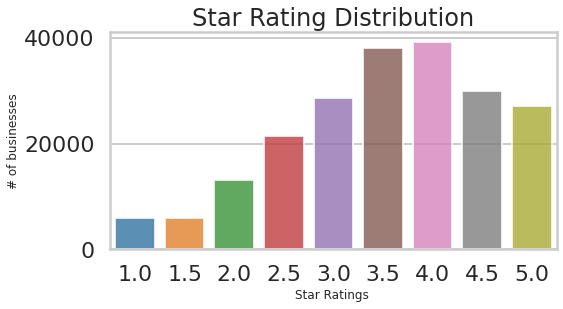

In [10]:
#Get the distribution of the ratings
x=business['stars'].value_counts()
x=x.sort_index()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Star Rating Distribution")
plt.ylabel('# of businesses', fontsize=12)
plt.xlabel('Star Ratings ', fontsize=12)

plt.show();

####Finding the top 10 business categories and also the distribution of restaurants in different places & selecting the city with the highest number of restaurants: 

First we eliminate all the cases where the business has no categories.Then we get hold of the categories and plot to have a look at which category has a decent amount of holdings in the dataset.Based on a that result, we will get hold of that category and further progress with our data analysis

In [11]:
business= business[business['categories'].notna()]


In [12]:
import re
categ=';'.join(business['categories'])
cat=re.split(';|,', categ)
business_categories=pd.DataFrame([item.strip() for item in cat],columns=['category'])#getting hold of the categories in the dataset

In [13]:
businesscount=business_categories.category.value_counts().sort_values(ascending = False)[:10]
businesscount

Restaurants         63944
Shopping            34644
Food                32991
Home Services       22487
Beauty & Spas       20520
Health & Medical    19227
Local Services      15783
Automotive          14720
Nightlife           14211
Bars                12400
Name: category, dtype: int64

Since we are going to exclusively deal with the restaurants,we will take the subset of the cases where the business is just Restaurant type:

In [14]:
Restaurants = business.loc[[i for i in business['categories'].index if re.search('Restaurants', business['categories'][i])]]#fetching only the restaurants in the business dataset

Reference - https://www.kaggle.com/dehaozhang/yelp-eda

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


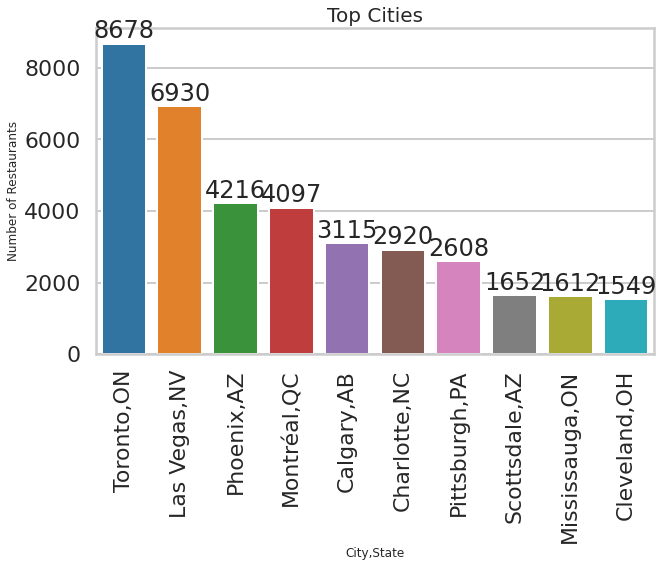

In [15]:

Restaurants['city_state'] = Restaurants['city'] + ',' + Restaurants['state']
city_count = Restaurants.city_state.value_counts().sort_values(ascending = False)[:10]

# plot
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(city_count.index, city_count.values)
plt.title("Top Cities",fontsize = 20)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 90)
plt.ylabel('Number of Restaurants', fontsize = 12)
plt.xlabel('City,State', fontsize = 12)

#text labels
r = ax.patches
labels = city_count.values
for rect, label in zip(r, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, ha='center', va='bottom')

_We see that Toronto,Ontario has the highest number of restaurants, followed by Las Vegas,Phoenix City and the rest. The Toronto subset also has an error where the state is mispelled as OH instead of ON. We take care of that case as well._

Now considering Toronto has the highest number of Restaurants, we subset our restaurant navigation further to just Toronto.

In [16]:
toronto_df=Restaurants[Restaurants.city=='Toronto']

In [17]:
toronto_df.to_pickle('Toronto_rest')

toronto_df['state'].unique()

array(['ON', 'OH'], dtype=object)

In [18]:
toronto_df = pd.read_pickle('/content/drive/MyDrive/Pickled Files/Toronto_rest')
toronto_df.shape

(8679, 15)

In [19]:
toronto_df=toronto_df.drop(['address','city','state','hours','city_state'],axis=1)

toronto_df=toronto_df[toronto_df.is_open==1]# taking only those restaurants which are open

toronto_df.shape

(5462, 10)

In [20]:
toronto_df=toronto_df.drop('is_open',axis=1)


Now, we notice that each business has multiple branches or outlets in Toronto, such as Tim Hortons has 58 instances with various ratings. This brings us to a plotting or analysis junction where we can which businesses have the highest number of outlets in Toronto.

In [21]:
toronto_df[toronto_df.name=='Tim Hortons'].shape # looking into the number of franchises of a particular business or food chain

(58, 9)

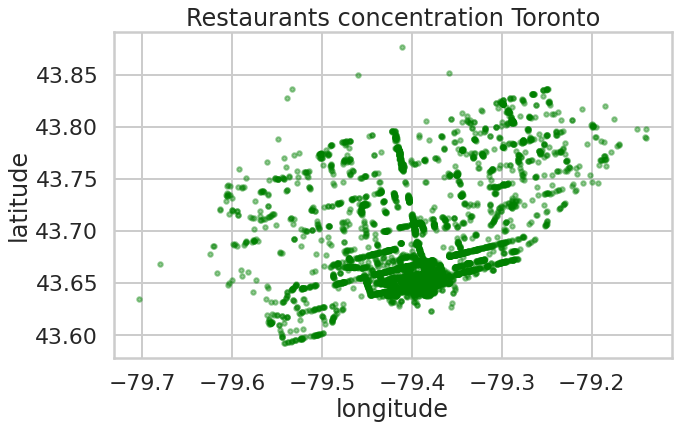

In [22]:
f, ax = plt.subplots(1, 1, figsize=(10,6))

#coordinates for Toronto from Google
lat_t = 43.6532
lon_t = -79.3832

lon_t_min, lon_t_max = lon_t-0.5,lon_t+0.5
lat_t_min, lat_t_max = lat_t-0.5,lat_t+0.5

#subset the data
map_=toronto_df[(toronto_df["longitude"]>lon_t_min) & (toronto_df["longitude"]<lon_t_max) &\
                    (toronto_df["latitude"]>lat_t_min) & (toronto_df["latitude"]<lat_t_max)]

#plot
map_.plot(kind='scatter', x='longitude', y='latitude',
                color='green',alpha=0.4, ax=ax)
ax.grid('off')
ax.set_title("Restaurants concentration Toronto");




####Plotting the top 20 restaurants of Toronto:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


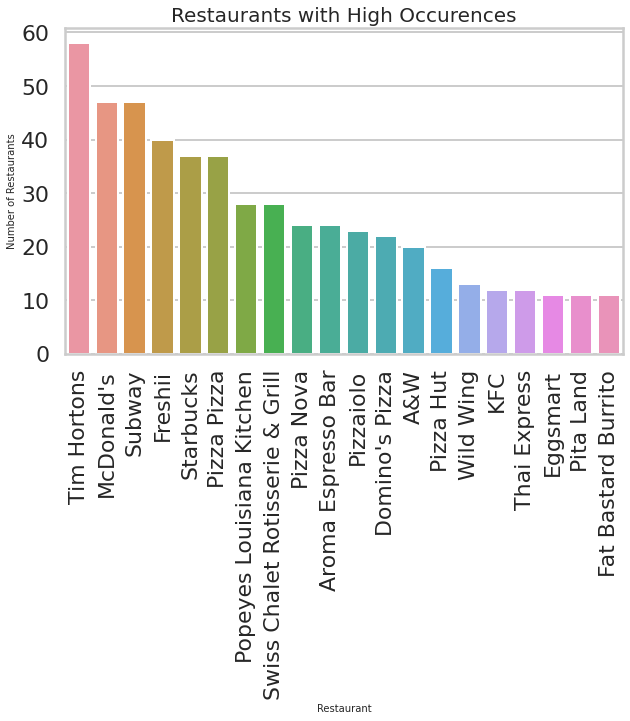

In [23]:
#Counting each of the restaurants in toronto

TopRes = toronto_df.name.value_counts().sort_values(ascending = False)[:20]
#plot
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(TopRes.index, TopRes.values)
plt.title("Restaurants with High Occurences",fontsize = 20)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 90)
plt.ylabel('Number of Restaurants', fontsize = 10)
plt.xlabel('Restaurant', fontsize = 10);

We see that Tim Hortons and Mc Donalds followed by Subway lead the graph with the highest number of occurences.These businesses seem to have opened lot of franchises/branches in the city. Although, it doesn't really mean that they have a strong positive response from the users in that aspect. We look into that as well in some of our EDA.

####Plotting the ratings obtained by Restaurants of the top 20 Restaurants:

We plot the average ratings and their standard deviations using box-plots for the top 20 restaurants

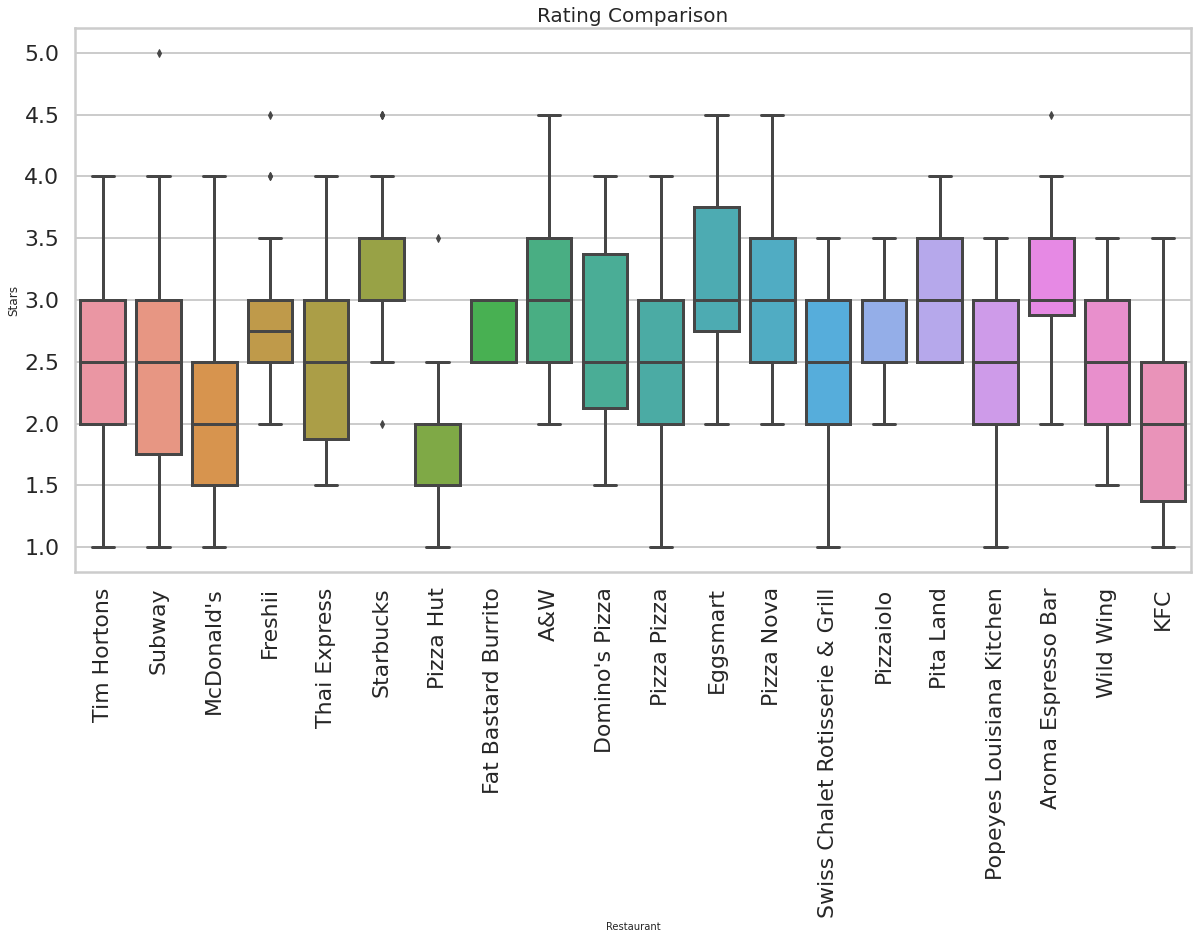

In [24]:
#boxplot of rating ranges and means of different food chains
fig = plt.figure(figsize=(20, 10))
sns.boxplot(x = 'name', y = 'stars', data = toronto_df[toronto_df.name.isin(TopRes.index)])
plt.title("Rating Comparison",fontsize = 20)
plt.ylabel('Stars', fontsize = 12)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 90)
plt.xlabel('Restaurant', fontsize = 10);

This boxplot gets use the mean ratings and the range of ratings received by each of these restaurants. There are a certain number of outliers in case of a few restaurants and for most of them,the outliers are high rankings, which is a good thing!

#### Further there is a relation between the stars received by the restaurants and review counts:

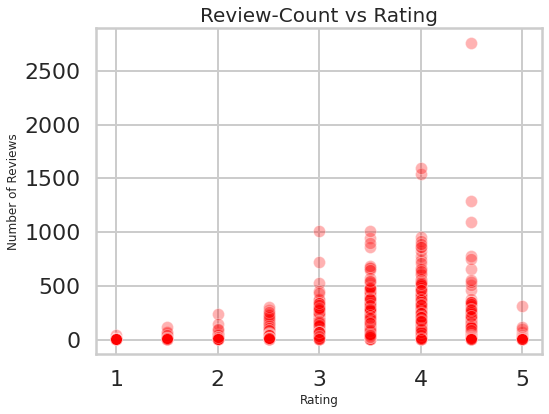

In [26]:
fig = plt.figure(figsize=(8, 6))
sns.scatterplot(x = 'stars', y = 'review_count',color='red',alpha=0.3 ,data = toronto_df)
plt.title("Review-Count vs Rating",fontsize = 20)
plt.ylabel('Number of Reviews', fontsize = 12)
plt.xlabel('Rating', fontsize = 12);

We see that the review count is mostly concentrated in the lower regions. Most ratings are based on less number of reviews and quite a few have received a high rating where the review count is also high. we might look at these Restaurants once where the **review count is more than 500 and the rating is above 3.5**

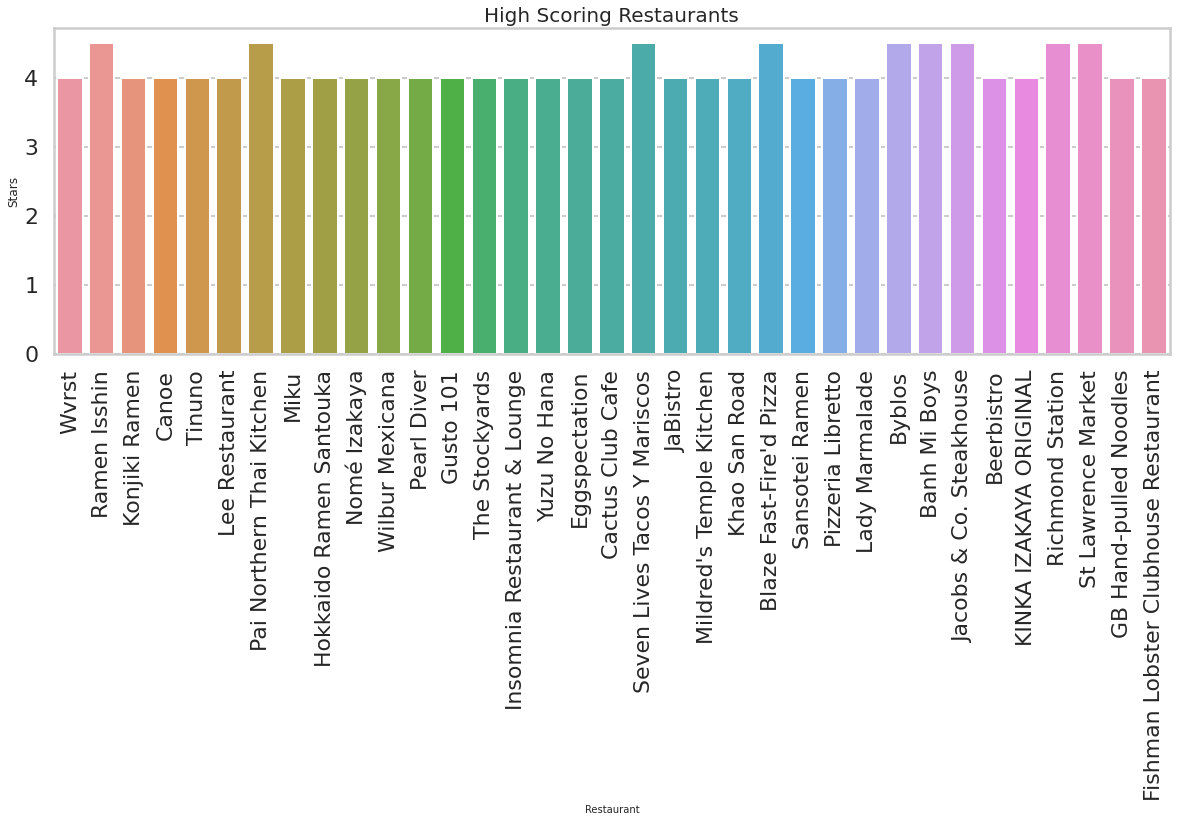

In [27]:
#Plotting restaurants based on above criteria 

df=toronto_df[(toronto_df.stars>3.5) &(toronto_df.review_count>500)]
fig,ax=plt.subplots(figsize=(20,6))
sns.barplot(data=df,x=df.name,y=df.stars,ax=ax)
plt.title("High Scoring Restaurants",fontsize = 20)
plt.ylabel('Stars', fontsize = 12)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 90)
plt.xlabel('Restaurant', fontsize = 10);

These few restaurants have received a high rating as well as have a good number of reviews. This implies that not only do they have a strong user base but they also seem to be liked by the users.

## Feature Engineering

##### We flatten the attributes part of the dataset which holds dictionary of the various attributes of the businesses

In [28]:
toronto_df['attributes'] = toronto_df['attributes'].apply(lambda x: {} if x is None else x)
#flatenning out attributes column
df = pd.json_normalize(toronto_df.attributes)


In [29]:
df.head()

,RestaurantsTakeOut,Alcohol,GoodForKids,RestaurantsPriceRange2,RestaurantsAttire,RestaurantsDelivery,Ambience,BusinessParking,RestaurantsGoodForGroups,RestaurantsReservations,OutdoorSeating,NoiseLevel,GoodForMeal,WiFi,BikeParking,RestaurantsTableService,HasTV,Caters,DriveThru,DogsAllowed,WheelchairAccessible,Music,HappyHour,BestNights,GoodForDancing,CoatCheck,Smoking,BusinessAcceptsCreditCards,BYOB,Corkage,ByAppointmentOnly,DietaryRestrictions,HairSpecializesIn,AcceptsInsurance,BusinessAcceptsBitcoin,AgesAllowed,RestaurantsCounterService
0,True,u'beer_and_wine',True,1,u'casual',False,"{'romantic': False, 'intimate': False, 'classy...","{'garage': False, 'street': True, 'validated':...",True,False,False,u'average',"{'dessert': False, 'latenight': False, 'lunch'...",u'no',True,True,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,True,'none',True,1,'casual',False,"{'touristy': False, 'hipster': False, 'romanti...","{'garage': False, 'street': False, 'validated'...",True,False,False,NaN,NaN,'no',False,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,True,'none',True,2,u'casual',True,"{'touristy': False, 'hipster': False, 'romanti...","{'garage': False, 'street': False, 'validated'...",True,False,True,'loud',"{'dessert': False, 'latenight': False, 'lunch'...",'no',True,False,True,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,True,NaN,NaN,1,NaN,NaN,NaN,"{'garage': False, 'street': False, 'validated'...",NaN,NaN,True,NaN,NaN,u'free',True,NaN,NaN,False,NaN,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,True,u'full_bar',True,3,u'casual',False,"{'romantic': False, 'intimate': False, 'classy...","{'garage': False, 'street': False, 'validated'...",True,True,False,u'loud',"{'dessert': False, 'latenight': False, 'lunch'...",'free',True,True,True,False,NaN,NaN,NaN,"{'dj': False, 'background_music': False, 'no_m...",True,"{'monday': False, 'tuesday': False, 'friday': ...",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
df.shape

(5462, 37)

##### We see that there are also columns like **BusinessParking, GoodForMeal** which need to be further flattened and we use the **atomicrows2** function below to do that




In [31]:
# Splitting the desired column and adding a prefix to the split columns

def atomicrows2(df,target_column,pre):

    def splitListToRows(row,row_accumulator,target_column,pre):

        new_row = row.to_dict()
        
        try:
            split_row = row[target_column].replace('\'', "").replace('{','').replace('}','').split(",")
        
            for i in split_row:

                if i is None:
                    
                    continue
                
                try:

                    new_row[pre+i.split(":")[0].strip()] = i.split(":")[1].replace('\'', "").strip()
                    
                except:

                    f = 0

        except:

            f = 1

        row_accumulator.append(new_row)

    new_rows = [] 
    df.apply(splitListToRows,axis=1,args = (new_rows,target_column,pre))
    new_df = pd.DataFrame(new_rows)
    return new_df


In [32]:
df = atomicrows2(df, 'GoodForMeal','meal_')
df.drop('GoodForMeal',axis=1,inplace=True)

In [33]:
df = atomicrows2(df, 'BusinessParking','bpark_')
df.drop('BusinessParking',axis=1,inplace=True)

In [34]:
df = atomicrows2(df, 'Music','m_')
df.drop('Music',axis=1,inplace=True)

In [35]:
df = atomicrows2(df, 'BestNights','bn_')
df.drop('BestNights',axis=1,inplace=True)

In [36]:
df = atomicrows2(df, 'DietaryRestrictions','dr_')
df.drop('DietaryRestrictions',axis=1,inplace=True)


In [37]:
df.head()

,RestaurantsTakeOut,Alcohol,GoodForKids,RestaurantsPriceRange2,RestaurantsAttire,RestaurantsDelivery,Ambience,RestaurantsGoodForGroups,RestaurantsReservations,OutdoorSeating,NoiseLevel,WiFi,BikeParking,RestaurantsTableService,HasTV,Caters,DriveThru,DogsAllowed,WheelchairAccessible,HappyHour,GoodForDancing,CoatCheck,Smoking,BusinessAcceptsCreditCards,BYOB,Corkage,ByAppointmentOnly,HairSpecializesIn,AcceptsInsurance,BusinessAcceptsBitcoin,AgesAllowed,RestaurantsCounterService,meal_dessert,meal_latenight,meal_lunch,meal_dinner,meal_brunch,meal_breakfast,bpark_garage,bpark_street,bpark_validated,bpark_lot,bpark_valet,m_dj,m_background_music,m_no_music,m_jukebox,m_live,m_video,m_karaoke,bn_monday,bn_tuesday,bn_friday,bn_wednesday,bn_thursday,bn_sunday,bn_saturday,dr_dairy-free,dr_gluten-free,dr_vegan,dr_kosher,dr_halal,dr_soy-free,dr_vegetarian
0,True,u'beer_and_wine',True,1,u'casual',False,"{'romantic': False, 'intimate': False, 'classy...",True,False,False,u'average',u'no',True,True,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,True,False,False,False,True,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,True,'none',True,1,'casual',False,"{'touristy': False, 'hipster': False, 'romanti...",True,False,False,NaN,'no',False,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,True,'none',True,2,u'casual',True,"{'touristy': False, 'hipster': False, 'romanti...",True,False,True,'loud','no',True,False,True,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,True,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,True,NaN,u'free',True,NaN,NaN,False,NaN,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,True,u'full_bar',True,3,u'casual',False,"{'romantic': False, 'intimate': False, 'classy...",True,True,False,u'loud','free',True,True,True,False,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
df.columns[33:]

Index(['meal_latenight', 'meal_lunch', 'meal_dinner', 'meal_brunch', 'meal_breakfast', 'bpark_garage', 'bpark_street', 'bpark_validated', 'bpark_lot', 'bpark_valet', 'm_dj', 'm_background_music', 'm_no_music', 'm_jukebox', 'm_live', 'm_video', 'm_karaoke', 'bn_monday', 'bn_tuesday', 'bn_friday', 'bn_wednesday', 'bn_thursday', 'bn_sunday', 'bn_saturday', 'dr_dairy-free', 'dr_gluten-free', 'dr_vegan', 'dr_kosher', 'dr_halal', 'dr_soy-free', 'dr_vegetarian'], dtype='object')

We do a table report on the split columns to check for any null data and we subsequently handle them

In [39]:
table_report(df[df.columns[33:]])

Table Shape (5462, 31)


,dtype,nulls,uniques,num_uniques,value_counts
meal_latenight,object,2030,"[False, nan, True, None]",4,False:3134nan:2030True:185None:113
meal_lunch,object,2030,"[True, nan, False, None]",4,False:2099nan:2030True:1261None:72
meal_dinner,object,2030,"[True, nan, False, None]",4,False:2103nan:2030True:1294None:35
meal_brunch,object,2030,"[False, nan, True, None]",4,False:3047nan:2030True:290None:95
meal_breakfast,object,2030,"[False, nan, True, None]",4,False:3171nan:2030True:197None:64
bpark_garage,object,1066,"[False, nan, True, None]",4,False:4118nan:1066True:220None:58
bpark_street,object,1066,"[True, False, nan, None]",4,False:2362True:1996nan:1066None:38
bpark_validated,object,1066,"[False, nan, True, None]",4,False:4297nan:1066None:50True:49
bpark_lot,object,1066,"[False, nan, True, None]",4,False:3645nan:1066True:738None:13
bpark_valet,object,1066,"[False, nan, True]",3,False:4325nan:1066True:71


In [40]:
df.shape

(5462, 64)

In [41]:
mod_cols = df.columns[32:]
#null handling
df[mod_cols] = df[mod_cols].fillna('False')

for i in mod_cols:
    df[i].replace('None','False',inplace=True) #imputations of the similar kind based on data observation
    

In [42]:
table_report(df)

Table Shape (5462, 64)


##### Using the **atomicrows** function, we get hold of the dictionary inside the ambience key of the attributes dictionaries and flatten it in order to get hold of the different ambiences provided by the different restaurants

In [43]:
def atomicrows(df,target_column):

    def splitListToRows(row,row_accumulator,target_column):

        new_row = row.to_dict()
        
        try:
            split_row = row[target_column]['Ambience'].replace('\'', "").replace('{','').replace('}','').split(",")
        
            for i in split_row:

                if i is None:
                    
                    continue
                
                try:

                    new_row["amb_"+i.split(":")[0].strip()] = i.split(":")[1].replace('\'', "").strip()
                    
                except:

                    f = 0

        except:

            f = 1

        row_accumulator.append(new_row)

    new_rows = [] 
    df.apply(splitListToRows,axis=1,args = (new_rows,target_column))
    new_df = pd.DataFrame(new_rows)
    return new_df


In [44]:
df2 = atomicrows(toronto_df,'attributes')

df2.shape

(5462, 18)

In [45]:
df2.head()

,business_id,name,postal_code,latitude,longitude,stars,review_count,attributes,categories,amb_romantic,amb_intimate,amb_classy,amb_hipster,amb_divey,amb_touristy,amb_trendy,amb_upscale,amb_casual
0,0QjROMVW9ACKjhSEfHqNCQ,Mi Mi Restaurant,M4M 1Y3,43.666376,-79.348773,4.0,116,"{'RestaurantsTakeOut': 'True', 'Alcohol': 'u'b...","Vietnamese, Restaurants",False,False,False,False,False,False,False,False,True
1,8k62wYhDVq1-652YbJi5eg,Tim Hortons,M5H 3V9,43.649859,-79.382060,3.0,8,"{'OutdoorSeating': 'False', 'RestaurantsDelive...","Bagels, Donuts, Food, Cafes, Coffee & Tea, Res...",False,False,False,False,NaN,False,False,False,False
2,0DnQh8SE8BSnvJltGCCiWg,Chick-N-Joy,M3A 1Z3,43.765279,-79.326248,3.0,11,"{'NoiseLevel': ''loud'', 'BusinessParking': '{...","Fast Food, Restaurants, Chicken Shop",False,False,False,False,NaN,False,False,False,False
3,NLaK58WvlNQdUunSIkt-jA,Zav Coffee Shop & Gallery,M4C 1J6,43.685608,-79.313936,4.5,24,"{'DogsAllowed': 'False', 'OutdoorSeating': 'Tr...","Coffee & Tea, Restaurants, Sandwiches, Food",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,cicPsia8Wj-DNRkmLbD_xg,The Keg Steakhouse + Bar,M4S 2B2,43.705843,-79.397841,3.5,91,"{'GoodForKids': 'True', 'RestaurantsGoodForGro...","Steakhouses, Restaurants, Nightlife, Seafood, ...",False,False,True,False,False,False,False,False,False


Here also we do a table report to see the different null values for the split columns and subsequently handle those

In [48]:
amb_cols = df2.columns[9:]

df2[amb_cols] = df2[amb_cols].fillna('False')

for i in amb_cols:
    df2[i].replace('None','False',inplace=True)


In [49]:
table_report(df2[amb_cols])

Table Shape (5462, 9)


,dtype,nulls,uniques,num_uniques,value_counts
amb_romantic,object,0,"[False, True]",2,False:5416True:46
amb_intimate,object,0,"[False, True]",2,False:5400True:62
amb_classy,object,0,"[False, True]",2,False:4638True:824
amb_hipster,object,0,"[False, True]",2,False:5311True:151
amb_divey,object,0,[False],1,False:5462
amb_touristy,object,0,"[False, True]",2,False:5450True:12
amb_trendy,object,0,"[False, True]",2,False:5240True:222
amb_upscale,object,0,"[False, True]",2,False:5416True:46
amb_casual,object,0,"[True, False]",2,False:3750True:1712


In [50]:
df2.to_pickle('toronto_restaurant_amb_added')

In [51]:
restaurants = pd.read_pickle('toronto_restaurant_amb_added')
restaurants=restaurants[restaurants.attributes.notnull()] #dropping restaurants with no attributes to work on

restaurants.shape

(5462, 18)

##### Now we combine the 2 flattened DF to get a combo df which has all the attributes fully flattened

In [52]:
res = pd.merge(restaurants,df,left_index=True,right_index=True)
res.shape

(5462, 82)

In [53]:
res.head()

,business_id,name,postal_code,latitude,longitude,stars,review_count,attributes,categories,amb_romantic,amb_intimate,amb_classy,amb_hipster,amb_divey,amb_touristy,amb_trendy,amb_upscale,amb_casual,RestaurantsTakeOut,Alcohol,GoodForKids,RestaurantsPriceRange2,RestaurantsAttire,RestaurantsDelivery,Ambience,RestaurantsGoodForGroups,RestaurantsReservations,OutdoorSeating,NoiseLevel,WiFi,BikeParking,RestaurantsTableService,HasTV,Caters,DriveThru,DogsAllowed,WheelchairAccessible,HappyHour,GoodForDancing,CoatCheck,Smoking,BusinessAcceptsCreditCards,BYOB,Corkage,ByAppointmentOnly,HairSpecializesIn,AcceptsInsurance,BusinessAcceptsBitcoin,AgesAllowed,RestaurantsCounterService,meal_dessert,meal_latenight,meal_lunch,meal_dinner,meal_brunch,meal_breakfast,bpark_garage,bpark_street,bpark_validated,bpark_lot,bpark_valet,m_dj,m_background_music,m_no_music,m_jukebox,m_live,m_video,m_karaoke,bn_monday,bn_tuesday,bn_friday,bn_wednesday,bn_thursday,bn_sunday,bn_saturday,dr_dairy-free,dr_gluten-free,dr_vegan,dr_kosher,dr_halal,dr_soy-free,dr_vegetarian
0,0QjROMVW9ACKjhSEfHqNCQ,Mi Mi Restaurant,M4M 1Y3,43.666376,-79.348773,4.0,116,"{'RestaurantsTakeOut': 'True', 'Alcohol': 'u'b...","Vietnamese, Restaurants",False,False,False,False,False,False,False,False,True,True,u'beer_and_wine',True,1,u'casual',False,"{'romantic': False, 'intimate': False, 'classy...",True,False,False,u'average',u'no',True,True,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,8k62wYhDVq1-652YbJi5eg,Tim Hortons,M5H 3V9,43.649859,-79.382060,3.0,8,"{'OutdoorSeating': 'False', 'RestaurantsDelive...","Bagels, Donuts, Food, Cafes, Coffee & Tea, Res...",False,False,False,False,False,False,False,False,False,True,'none',True,1,'casual',False,"{'touristy': False, 'hipster': False, 'romanti...",True,False,False,NaN,'no',False,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,0DnQh8SE8BSnvJltGCCiWg,Chick-N-Joy,M3A 1Z3,43.765279,-79.326248,3.0,11,"{'NoiseLevel': ''loud'', 'BusinessParking': '{...","Fast Food, Restaurants, Chicken Shop",False,False,False,False,False,False,False,False,False,True,'none',True,2,u'casual',True,"{'touristy': False, 'hipster': False, 'romanti...",True,False,True,'loud','no',True,False,True,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,NLaK58WvlNQdUunSIkt-jA,Zav Coffee Shop & Gallery,M4C 1J6,43.685608,-79.313936,4.5,24,"{'DogsAllowed': 'False', 'OutdoorSeating': 'Tr...","Coffee & Tea, Restaurants, Sandwiches, Food",False,False,False,False,False,False,False,False,False,True,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,True,NaN,u'free',True,NaN,NaN,False,NaN,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,cicPsia8Wj-DNRkmLbD_xg,The Keg Steakhouse + Bar,M4S 2B2,43.705843,-79.397841,3.5,91,"{'GoodForKids': 'True', 'RestaurantsGoodForGro...","Steakhouses, Restaurants, Nightlife, Seafood, ...",False,False,True,False,False,False,False,False,False,True,u'full_bar',True,3,u'casual',False,"{'romantic': False, 'intimate': False, 'classy...",True,True,False,u'loud','free',True,True,True,False,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,True,False,False,False,False,False,False,False,False,False,False,Fals

We drop the Ambience and attributes columns since we have already flattened them out. Also we drop the column HairSpecializesIn since it makes no sense to include that attribute in the rating of a restaurant

In [54]:
res.drop('Ambience',axis=1,inplace=True)
res.drop('HairSpecializesIn',axis=1,inplace=True)
res.drop('attributes',axis=1,inplace=True)

We have flattened the attributes and now we handle the NaNs and impute certain values and handle the missing values accordingly

In [55]:
res['RestaurantsPriceRange2']=res['RestaurantsPriceRange2'].replace(np.nan,0)
res['RestaurantsAttire']=res['RestaurantsAttire'].replace(np.nan,"streets")
res['Alcohol']=res['Alcohol'].replace(np.nan,"u'none'")
res['Caters']=res['Caters'].replace(np.nan,"False")
for i in res.columns[13:]:
  res[i]=res[i].replace(np.nan,"False")
  res[i].replace('None','False',inplace=True)




The below-mentioned columns **WiFi, Smoking, RestaurantsAttire, Alcohol, NoiseLevel, RestaurantsPriceRange2** had some anomalies as discovered using the table report function and we have accordingly handled those anomalies (like unicode string, having same words with quotes etc.)

In [56]:
res['WiFi'] = res['WiFi'].apply(lambda x: x.encode('utf-8').decode('utf-8').strip().replace('\'', ""))

res['WiFi'] = res['WiFi'].apply(lambda x: x[1:] if x[0]=="u" else x )

res['WiFi'].replace('no','False',inplace=True)

res['WiFi'].replace("'paid'",'paid',inplace=True)



In [57]:

res['Smoking'] = res['Smoking'].apply(lambda x: x.encode('utf-8').decode('utf-8').strip().replace('\'', ""))

res['Smoking'] = res['Smoking'].apply(lambda x: x[1:] if x[0]=="u" else x )


res['Smoking'].replace('no','False',inplace=True)


In [58]:

res['RestaurantsAttire'] = res['RestaurantsAttire'].apply(lambda x: x[1:] if x[0]=="u" else x )
res['RestaurantsAttire'].replace("False","streets",inplace=True)

In [59]:
res['Alcohol'] = res['Alcohol'].apply(lambda x: x.encode('utf-8').decode('utf-8'))
res['Alcohol'] = res['Alcohol'].apply(lambda x: x[1:] if x[0]=="u" else x )
res['Alcohol'].replace('False','none',inplace=True)

In [60]:
res['NoiseLevel'] = res['NoiseLevel'].apply(lambda x: x.encode('utf-8').decode('utf-8'))
res['NoiseLevel'] = res['NoiseLevel'].apply(lambda x: x[1:] if x[0]=="u" else x )

In [61]:
res['RestaurantsPriceRange2'].replace('False',0,inplace=True)

In [62]:
table_report(res)

Table Shape (5462, 79)


Next we convert the required columns to categoricals and we do a table_report to check the values

In [63]:
for i in res.columns[9:]:
  res[i]=res[i].astype('category').cat.codes.values

In [64]:
res.dtypes

business_id       object
name              object
postal_code       object
latitude         float64
longitude        float64
                  ...   
dr_vegan            int8
dr_kosher           int8
dr_halal            int8
dr_soy-free         int8
dr_vegetarian       int8
Length: 79, dtype: object

In [65]:
table_report(res)

Table Shape (5462, 79)


In [66]:
res.to_pickle("Toronto_Rest_Flat_Clean")

In [67]:
res = pd.read_pickle("Toronto_Rest_Flat_Clean")

##### Next we find the correlations between all the columns and star-rating of restaurants to find which factors influence the star-rating of a restaurant using **Pearson-R**

In [68]:
from scipy.stats.stats import pearsonr

cols = res.columns[9:]

df_list=[]

for i in cols:
    #finding the pearsonr coefficient between the stars column and the attributes
    value = pearsonr(res[i],res['stars'])

    corr = {'Feature':i , 'corr':value[0] , 'abscorr':abs(value[0])}

    df_list.append(corr)

df_corr = pd.DataFrame(df_list)

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [69]:
corr=df_corr.sort_values(by='abscorr',ascending=False)[:25]
corr

,Feature,corr,abscorr
45,bpark_street,0.203068,0.203068
20,RestaurantsTableService,0.136863,0.136863
25,WheelchairAccessible,0.127637,0.127637
1,amb_classy,0.123654,0.123654
22,Caters,0.123254,0.123254
19,BikeParking,0.120480,0.120480
41,meal_dinner,0.113992,0.113992
7,amb_casual,0.092395,0.092395
40,meal_lunch,0.092316,0.092316
15,RestaurantsReservations,0.090806,0.090806


The pearsonr function helps us to find the correlation between several attributes and stars and see if any of them have a effect on the ratings given by the users and then, we print the top 25 of them based on the absolute value of the correlation, irrespective, of whether positive or negative correlation.

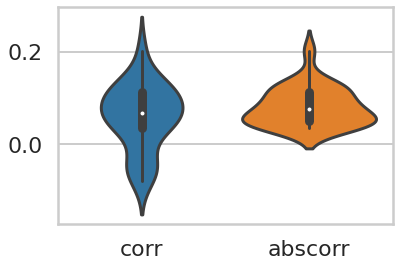

In [70]:
sns.violinplot(data=corr);

###### We make plots to see more clearly which factors are influencing the star rating

In [71]:
corr_matrix = res.corr()
#correlation matrix between the attributes
corr_avg_stars = corr_matrix['stars'].sort_values(ascending=False)
corr_avg_stars.pop('stars')

corr_avg_stars.index

Index(['bpark_street', 'review_count', 'RestaurantsTableService', 'WheelchairAccessible', 'amb_classy', 'Caters', 'BikeParking', 'meal_dinner', 'amb_casual', 'meal_lunch', 'RestaurantsReservations', 'WiFi', 'amb_trendy', 'amb_hipster', 'RestaurantsAttire', 'amb_intimate', 'OutdoorSeating', 'meal_brunch', 'DogsAllowed', 'HappyHour', 'RestaurantsPriceRange2', 'CoatCheck', 'meal_breakfast', 'meal_dessert', 'dr_gluten-free', 'BusinessAcceptsCreditCards', 'bpark_valet', 'bpark_lot', 'amb_upscale', 'bn_saturday', 'BYOB', 'bpark_garage', 'm_background_music', 'bn_thursday', 'bn_friday', 'bpark_validated', 'AcceptsInsurance', 'AgesAllowed', 'RestaurantsCounterService', 'dr_vegan', 'bn_tuesday', 'bn_sunday', 'm_live', 'bn_monday', 'dr_vegetarian', 'Corkage', 'ByAppointmentOnly', 'm_video', 'amb_touristy', 'bn_wednesday', 'm_jukebox', 'Smoking', 'm_dj', 'dr_halal', 'm_karaoke', 'RestaurantsTakeOut', 'GoodForDancing', 'RestaurantsGoodForGroups', 'meal_latenight', 'GoodForKids', 'HasTV',
       'N

We further do a barplot for the correlations between the attribute features and stars and get a visualisation for the same.The first 10 seem to be quite important attributes that need to be in our dataset for feature Engineering purposes.

Text(0, 0.5, 'Corr')

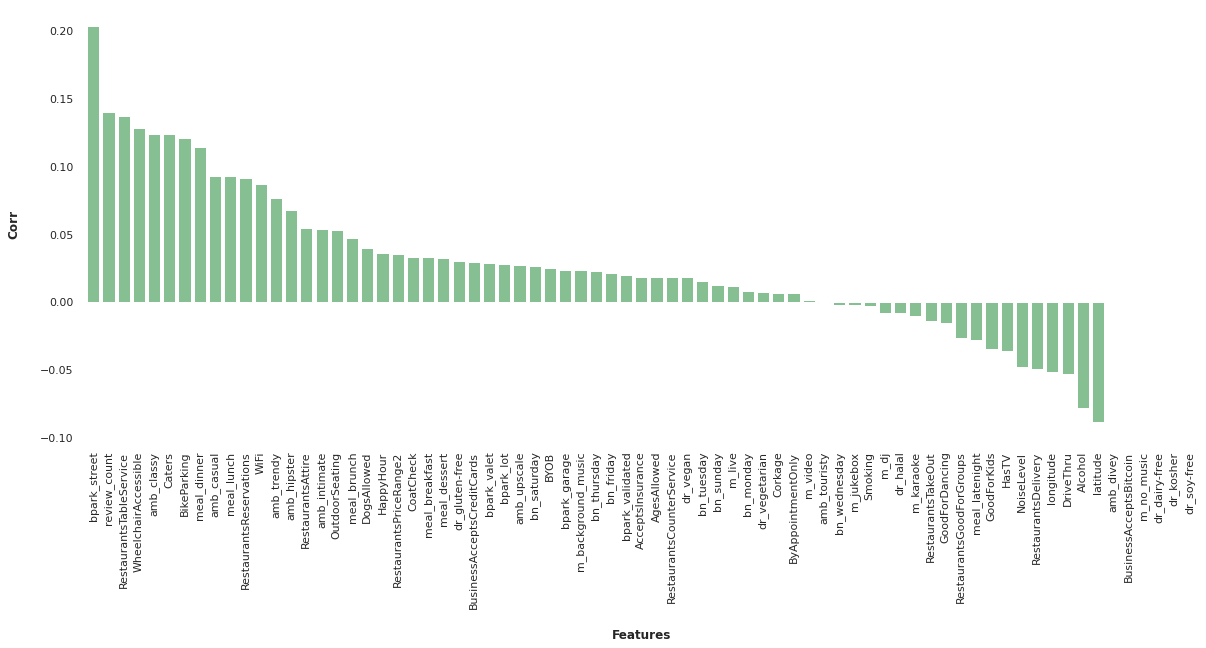

In [75]:
ax = corr_avg_stars.plot(kind='bar', sharex=False, figsize=(20,8), color = '#86bf91', zorder=2, width=0.8)

#despine
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_xlabel('Features', labelpad=20, weight='bold')
ax.set_ylabel('Corr', labelpad=20, weight='bold')





We try and plot a heatmap between the attributes to see which of these attributes will be use for modelling and predition.Apparently,bpark_street,review_count,RestaurantsTableService,GoodForDancing,amb_classy, alcohol, WheelchairAccessible seem important attributes,to keep in our dataset.

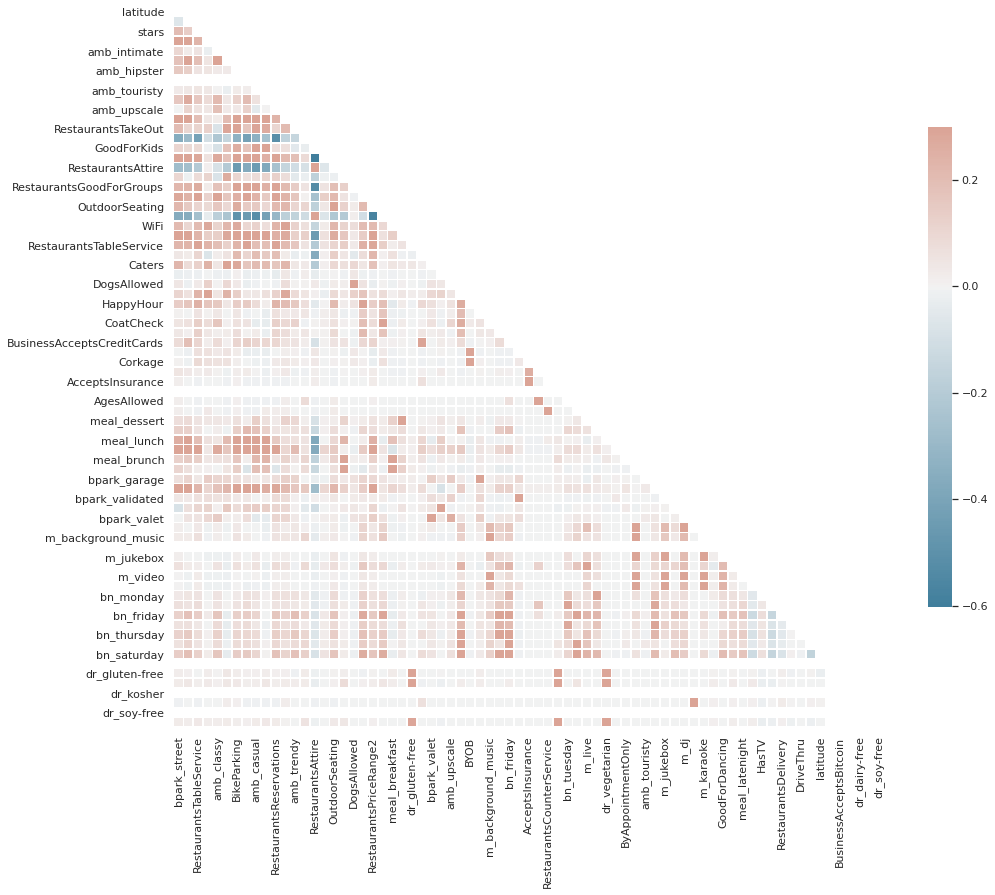

In [76]:
sns.set_theme(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)


# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(res.corr()[corr_avg_stars.index], dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(res.corr()[corr_avg_stars.index], mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.tight_layout()


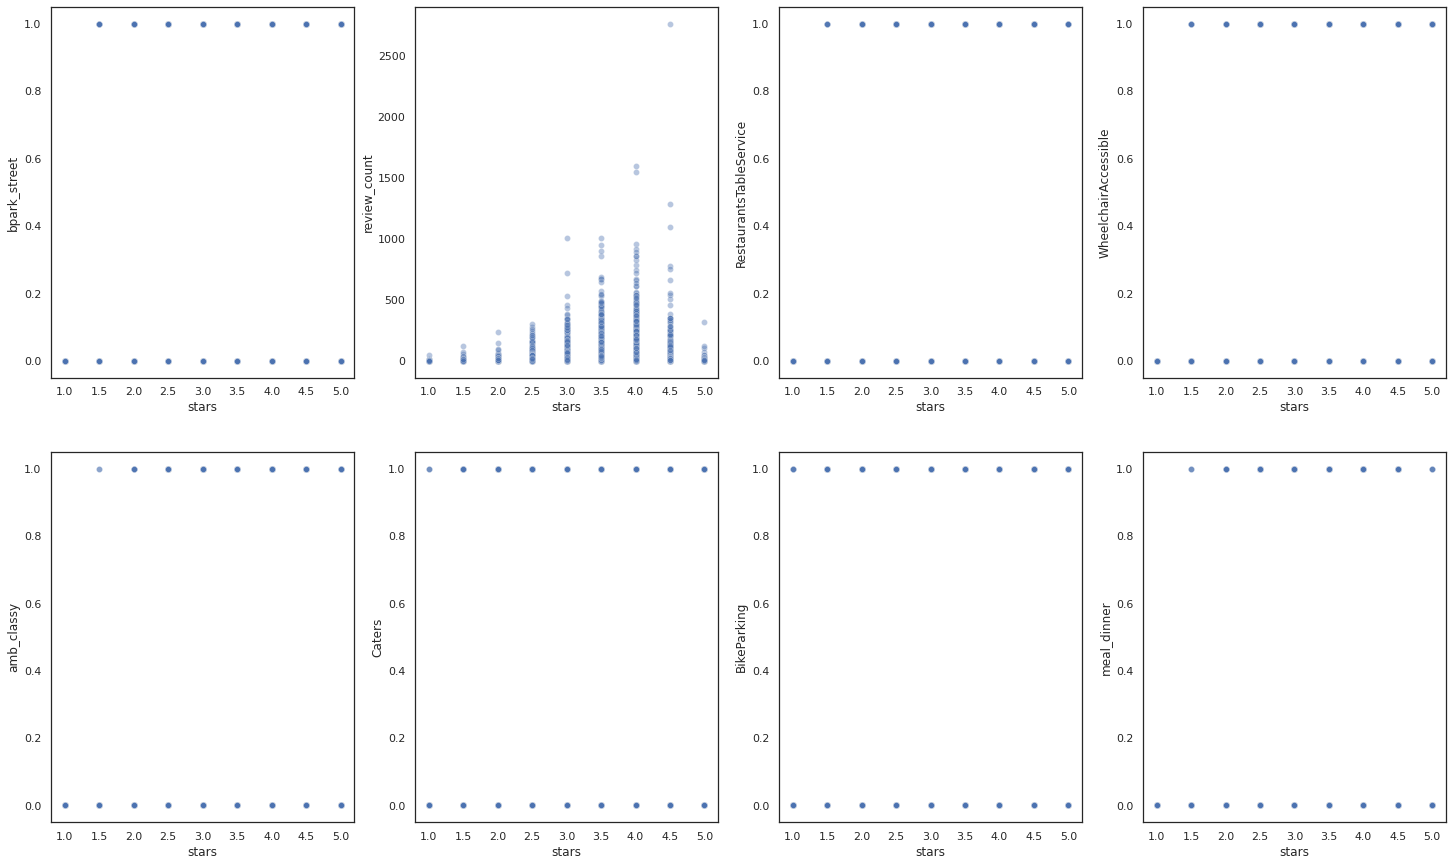

In [74]:
fig,axes = plt.subplots(nrows=2, ncols=4, figsize=(25,15))
axes = axes.flatten()
for i, y in enumerate(corr_avg_stars.index[:8]):
    sns.scatterplot(x =res['stars'], y = res[y], ax= axes[i], alpha=0.4)
    #axes[i].set_yscale('log')

##### We further flatten the category column in order to increase more number of latent Factors in our Data

In [77]:
df = pd.Series(res['categories']).str.get_dummies(',')


In [78]:
df.columns = df.columns.str.strip()

df.drop(['Food','Restaurants'],axis=1,inplace=True)

df.shape

(5462, 545)

In [79]:
ratings=pd.DataFrame(res[['stars','categories']],index=res.index,columns=['stars','categories'])
ratings=pd.merge(ratings,df,left_index=True,right_index=True)

In [80]:
ratings

,stars,categories,Acai Bowls,Accessories,Accountants,Acne Treatment,Active Life,Afghan,African,Alternative Medicine,American (New),American (Traditional),Amusement Parks,Antiques,Appliances,Arabian,Arcades,Argentine,Art Classes,Art Galleries,Art Schools,Arts & Crafts,Arts & Entertainment,Asian Fusion,Australian,Automotive,Bagels,Bakeries,Bangladeshi,Barbeque,Bars,Bartenders,Beauty & Spas,Beer,Beer Bar,Belgian,Bistros,Bocce Ball,Books,Bookstores,Bowling,Brasseries,Brazilian,Breakfast & Brunch,Breweries,Brewpubs,British,Bubble Tea,Buffets,Burgers,...,Pool Halls,Pop-Up Restaurants,Portuguese,Poutineries,Pubs,Ramen,Recreation Centers,Roofing,Salad,Sandwiches,Seafood,Seafood Markets,Shaved Ice,Shaved Snow,Shopping,Shopping Centers,Smokehouse,Social Clubs,Soul Food,Soup,Southern,Spanish,Speakeasies,Specialty Food,Sports Bars,Sri Lankan,Steakhouses,Street Vendors,Sushi Bars,Swiss Food,Syrian,Tacos,Taiwanese,Tapas Bars,Tapas/Small Plates,Tea Rooms,Tex-Mex,Thai,Themed Cafes,Turkish,Ukrainian,Vegan,Vegetarian,Vietnamese,Waffles,Whiskey Bars,Wine Bars,Wineries,Women's Clothing,Yelp Events
0,4.0,"Vietnamese, Restaurants",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,3.0,"Bagels, Donuts, Food, Cafes, Coffee & Tea, Res...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3.0,"Fast Food, Restaurants, Chicken Shop",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4.5,"Coffee & Tea, Restaurants, Sandwiches, Food",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3.5,"Steakhouses, Restaurants, Nightlife, Seafood, ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5457,4.0,"Sushi Bars, Restaurants, Japanese",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5458,3.5,"Mexican, Restaurants",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5459,4.0,"Vegan, Restaurants, Vegetarian, Salad",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
5460,4.0,"Restaurants, Mediterranean",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


The ratings Dataset has 547 columns which, if added further to increase the number of latent factors for the businesses doesn't really help,as they are sparsely valued and might just add to more mis-specification without any improvement. Hence, we keep them notably, away from our business data, now the 'res' dataset.

###EDA

Now we do some EDA on the categories obtained:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


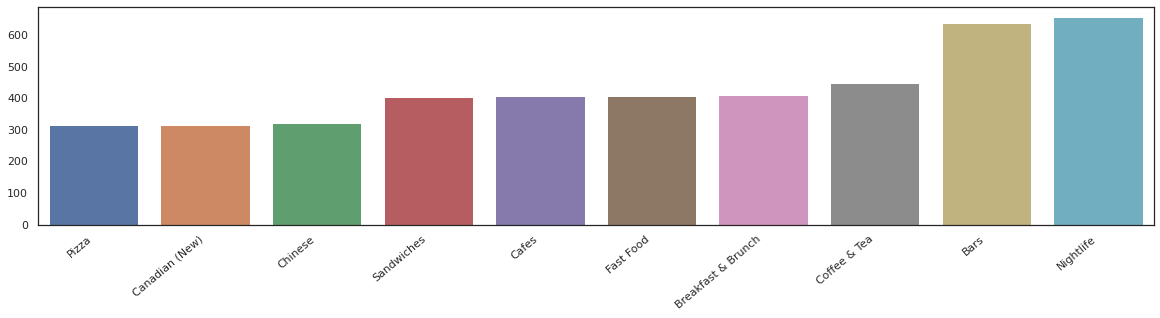

In [81]:
top_cats = df.sum().sort_values()[-10:]

plt.figure(figsize=(20,4))
ax = sns.barplot(top_cats.index,top_cats.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

The categories of Bar,NightLife and Coffee&Tea seem to have a strong hold on the market of Toronto. The Cafes,Fast Food, BreakFast and Brunch seem to be do more or less in the same range.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


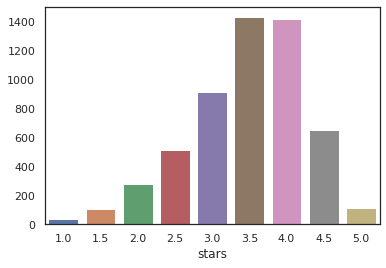

In [82]:
ratings = res.groupby('stars').count()['review_count']
sns.barplot(ratings.index,ratings.values)

Comparing the relations between the stars and review counts, we see most People or users have rated the businesses decently,implying that the restaurants of Toronto, seem to be doing well, in matters of response from the people.

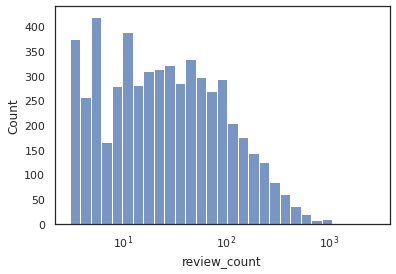

In [83]:
sns.histplot(res['review_count'],log_scale=True)

On plotting the review counts for different businesses, we see that most business ratings are based on poor number of reviews and hence, the ratings don't have a strong credibility in these cases.

##The Review Dataset:

In [85]:
#Helper function to read the huge reviews.json file 

import json 
def init_ds(json):
  ds={}
  keys = json.keys() 
  for k in keys:
     ds[k]= []
  return ds, keys 
def read_json(file): 
  dataset = {}
  keys = [] 
  with open(file) as file_lines:
    for count, line in enumerate(file_lines):
       data = json.loads(line.strip()) 
       if count ==0:
          dataset, keys = init_ds(data)
       for k in keys: 
         dataset[k].append(data[k]) 

    return pd.DataFrame(dataset)

In [86]:
reviews = read_json("drive/MyDrive/yelp_academic_dataset_review.json")

In [87]:
reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2.0,5,0,0,"As someone who has worked with many museums, I...",2015-04-15 05:21:16
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1.0,1,1,0,I am actually horrified this place is still in...,2013-12-07 03:16:52
2,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5.0,1,0,0,I love Deagan's. I do. I really do. The atmosp...,2015-12-05 03:18:11
3,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,5JxlZaqCnk1MnbgRirs40Q,1.0,0,0,0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",2011-05-27 05:30:52
4,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4.0,0,0,0,"Oh happy day, finally have a Canes near my cas...",2017-01-14 21:56:57


In [88]:
reviews=reviews.drop(['text','date'],axis=1)

In [89]:
business=res.business_id.unique()
reviews=reviews[reviews.business_id.isin(business)]


We remove the date and text columns as reviews don't matter, as we already have the rating of that user for that particular restaurant.Also, the date of the review doesn't really concern us.

In [90]:
#reviews=reviews.drop('review_id',axis=1)

Creating a new Column 'response' which gets hold of the outlook of the user for logistic regresion purposes(if needed) and predict if the user will have a positive response for a certain restaurant that he hasn't been to before.

In [91]:
reviews['response']=[1 if y>3.5 else 0 for y in reviews['stars']]

In [92]:
res.head()

,business_id,name,postal_code,latitude,longitude,stars,review_count,categories,amb_romantic,amb_intimate,amb_classy,amb_hipster,amb_divey,amb_touristy,amb_trendy,amb_upscale,amb_casual,RestaurantsTakeOut,Alcohol,GoodForKids,RestaurantsPriceRange2,RestaurantsAttire,RestaurantsDelivery,RestaurantsGoodForGroups,RestaurantsReservations,OutdoorSeating,NoiseLevel,WiFi,BikeParking,RestaurantsTableService,HasTV,Caters,DriveThru,DogsAllowed,WheelchairAccessible,HappyHour,GoodForDancing,CoatCheck,Smoking,BusinessAcceptsCreditCards,BYOB,Corkage,ByAppointmentOnly,AcceptsInsurance,BusinessAcceptsBitcoin,AgesAllowed,RestaurantsCounterService,meal_dessert,meal_latenight,meal_lunch,meal_dinner,meal_brunch,meal_breakfast,bpark_garage,bpark_street,bpark_validated,bpark_lot,bpark_valet,m_dj,m_background_music,m_no_music,m_jukebox,m_live,m_video,m_karaoke,bn_monday,bn_tuesday,bn_friday,bn_wednesday,bn_thursday,bn_sunday,bn_saturday,dr_dairy-free,dr_gluten-free,dr_vegan,dr_kosher,dr_halal,dr_soy-free,dr_vegetarian
0,0QjROMVW9ACKjhSEfHqNCQ,Mi Mi Restaurant,M4M 1Y3,43.666376,-79.348773,4.0,116,"Vietnamese, Restaurants",False,0,0,0,0,0,0,0,1,1,0,1,1,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,8k62wYhDVq1-652YbJi5eg,Tim Hortons,M5H 3V9,43.649859,-79.382060,3.0,8,"Bagels, Donuts, Food, Cafes, Coffee & Tea, Res...",False,0,0,0,0,0,0,0,0,1,2,1,1,0,0,1,0,0,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0DnQh8SE8BSnvJltGCCiWg,Chick-N-Joy,M3A 1Z3,43.765279,-79.326248,3.0,11,"Fast Food, Restaurants, Chicken Shop",False,0,0,0,0,0,0,0,0,1,2,1,2,0,1,1,0,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,NLaK58WvlNQdUunSIkt-jA,Zav Coffee Shop & Gallery,M4C 1J6,43.685608,-79.313936,4.5,24,"Coffee & Tea, Restaurants, Sandwiches, Food",False,0,0,0,0,0,0,0,0,1,2,0,1,3,0,0,0,1,4,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,cicPsia8Wj-DNRkmLbD_xg,The Keg Steakhouse + Bar,M4S 2B2,43.705843,-79.397841,3.5,91,"Steakhouses, Restaurants, Nightlife, Seafood, ...",False,0,1,0,0,0,0,0,0,1,1,1,3,0,0,1,1,0,1,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


As we remember, the Tim Hortons, Mc Donalds and Subway had the highest number of outlets. Let's see what is the response of people based on their ratings for these businesses.

In [93]:
resp=res[res.name.isin(TopRes.index)][['business_id','name']]
resp.reset_index()

,index,business_id,name
0,1,8k62wYhDVq1-652YbJi5eg,Tim Hortons
1,33,AOhJfJVuEPUh_in7WHDnzQ,Subway
2,36,2vuAlukfUZf3vbHsexEeDw,McDonald's
3,38,kwXTdolA_0G2haHW4To5kA,Freshii
4,44,_o2fJBcVgLpy-L970Y7qYQ,Thai Express
...,...,...,...
516,5415,kqW_BKO3XCOx8ifbzQsnGA,McDonald's
517,5434,q9X0rwLBGehmRwXFqlWE-A,Aroma Espresso Bar
518,5442,vQXhuCQ4Wc3WWesp9hy3VQ,Pizza Hut
519,5447,undz-LtXIta312RP_DqmFQ,Subway


In [94]:
resp=pd.merge(resp,reviews,how='inner',on="business_id")

In [95]:
#resp.groupby("business_id")['stars'].mean()

#####Plotting for Tim Hortons:

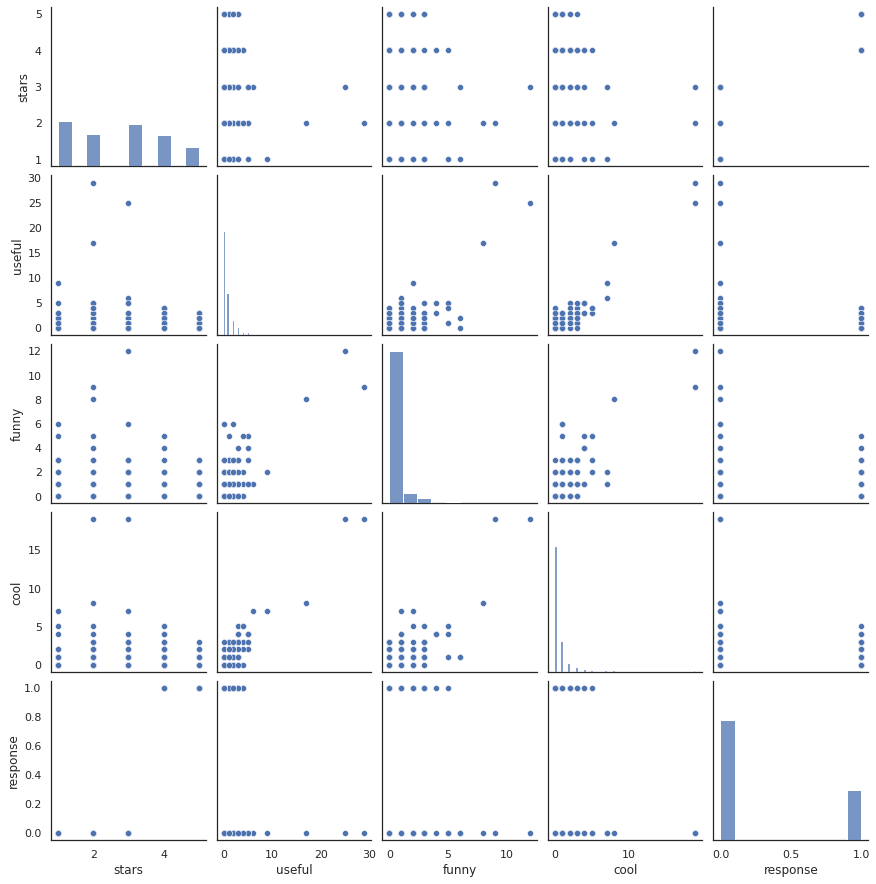

In [96]:
sns.pairplot(data=resp[resp.name=='Tim Hortons'])

We get a pairplot to see the correlations  between the various columns of the review dataset based on th Tim Hortons case and we see that users who have given funny reviews,seem to have also given greater number of ratings,compared to other.

####Plotting for Subways:

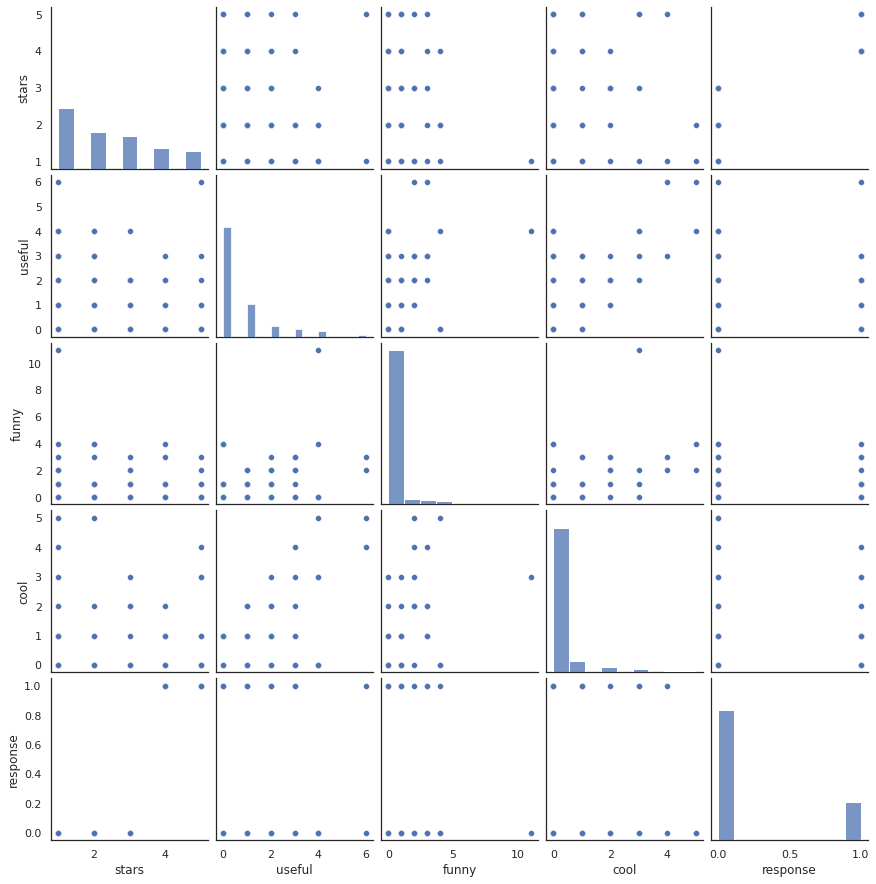

In [97]:
sns.pairplot(data=resp[resp.name=='Subway'])

In case of Subway, we see that, users with cool reviews seem to have given more number of ratings to the Subways.

####Plotting for both:

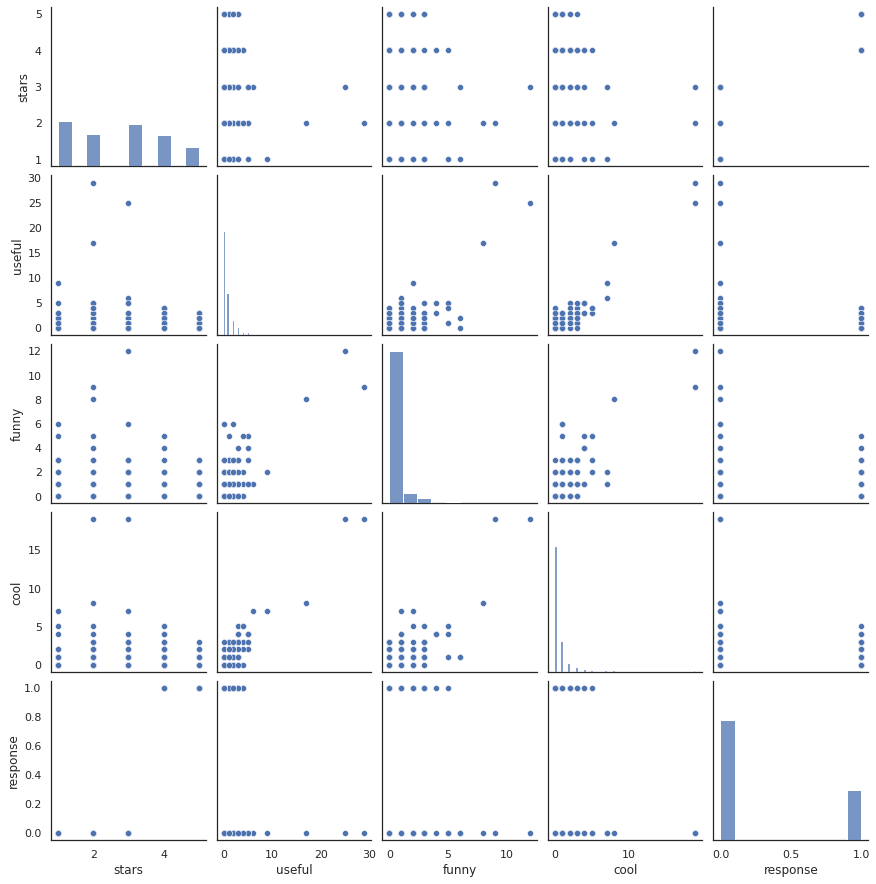

In [98]:
sns.pairplot(data=resp[resp.name.isin(['Tim Hortons','Subways'])])

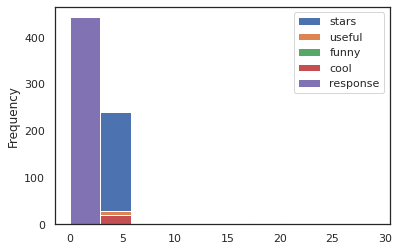

In [99]:
resp[resp.name.isin(['Tim Hortons','Subways'])].plot(kind='hist')

Both the Tim Hortons and Subway have obtained, good number of responses, a good number of ratings,very few useful but mostly cool reviews. These responses are majorly, because of the strong market hold of these businesses as stated and visualised earlier.

###Looking into the Users with the maximum number of reviews:

Reference- https://www.kaggle.com/jagangupta/what-s-in-a-review-yelp-ratings-eda

In [100]:
user=reviews.groupby('user_id').agg({'review_id':['count'],'stars':['mean']})

In [101]:
user=user.sort_values([('review_id','count')],ascending=False)

In [102]:
user.head(10)

,review_id,stars
,count,mean
user_id,,
CxDOIDnH8gp9KXzpBHJYXw,718,3.345404
Q9mA60HnY87C1TW5kjAZ6Q,451,4.024390
O3pSxv1SyHpY4qi4Q16KzA,435,3.358621
ic-tyi1jElL_umxZVh8KNA,401,3.496259
iRQ_YKpCBdaCwvc2X8_3NQ,394,3.401015
1fNQRju9gmoCEvbPQBSo7w,333,3.093093
gwIqbXEXijQNgdESVc07hg,306,3.019608
YBT3EKUNN4IP8m4x7sGu1g,281,3.960854


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


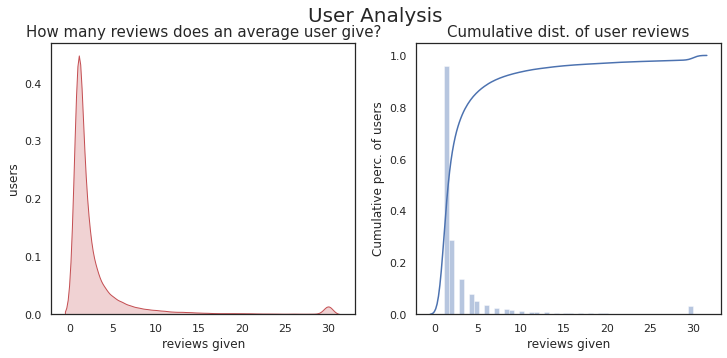

In [103]:
user[('review_id','count')].loc[user[('review_id','count')]>30] = 30
plt.figure(figsize=(12,5))
plt.suptitle("User Analysis",fontsize=20)

plt.subplot2grid((1,2),(0,0))
#Cumulative Distribution
ax=sns.kdeplot(user[('review_id','count')],shade=True,color='r')
plt.title("How many reviews does an average user give?",fontsize=15)
plt.xlabel('reviews given', fontsize=12)
plt.ylabel('users', fontsize=12)

#Cumulative Distribution
plt.subplot2grid((1,2),(0,1))
sns.distplot(user[('review_id','count')],
             kde_kws=dict(cumulative=True))
plt.title("Cumulative dist. of user reviews",fontsize=15)
plt.ylabel('Cumulative perc. of users', fontsize=12)
plt.xlabel('reviews given', fontsize=12)

plt.show();


## Baseline Modelling

For the baseline model, we use the formula given by **Koren and Bell** in their **Advanced collaborative Filtering** paper to obtain the user &restaurants bias and the average ratings for Toronto Restaurants across the Yelp dataset

In [106]:
from sklearn.model_selection import train_test_split

In [107]:
res.head()

,business_id,name,postal_code,latitude,longitude,stars,review_count,categories,amb_romantic,amb_intimate,amb_classy,amb_hipster,amb_divey,amb_touristy,amb_trendy,amb_upscale,amb_casual,RestaurantsTakeOut,Alcohol,GoodForKids,RestaurantsPriceRange2,RestaurantsAttire,RestaurantsDelivery,RestaurantsGoodForGroups,RestaurantsReservations,OutdoorSeating,NoiseLevel,WiFi,BikeParking,RestaurantsTableService,HasTV,Caters,DriveThru,DogsAllowed,WheelchairAccessible,HappyHour,GoodForDancing,CoatCheck,Smoking,BusinessAcceptsCreditCards,BYOB,Corkage,ByAppointmentOnly,AcceptsInsurance,BusinessAcceptsBitcoin,AgesAllowed,RestaurantsCounterService,meal_dessert,meal_latenight,meal_lunch,meal_dinner,meal_brunch,meal_breakfast,bpark_garage,bpark_street,bpark_validated,bpark_lot,bpark_valet,m_dj,m_background_music,m_no_music,m_jukebox,m_live,m_video,m_karaoke,bn_monday,bn_tuesday,bn_friday,bn_wednesday,bn_thursday,bn_sunday,bn_saturday,dr_dairy-free,dr_gluten-free,dr_vegan,dr_kosher,dr_halal,dr_soy-free,dr_vegetarian
0,0QjROMVW9ACKjhSEfHqNCQ,Mi Mi Restaurant,M4M 1Y3,43.666376,-79.348773,4.0,116,"Vietnamese, Restaurants",False,0,0,0,0,0,0,0,1,1,0,1,1,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,8k62wYhDVq1-652YbJi5eg,Tim Hortons,M5H 3V9,43.649859,-79.382060,3.0,8,"Bagels, Donuts, Food, Cafes, Coffee & Tea, Res...",False,0,0,0,0,0,0,0,0,1,2,1,1,0,0,1,0,0,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0DnQh8SE8BSnvJltGCCiWg,Chick-N-Joy,M3A 1Z3,43.765279,-79.326248,3.0,11,"Fast Food, Restaurants, Chicken Shop",False,0,0,0,0,0,0,0,0,1,2,1,2,0,1,1,0,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,NLaK58WvlNQdUunSIkt-jA,Zav Coffee Shop & Gallery,M4C 1J6,43.685608,-79.313936,4.5,24,"Coffee & Tea, Restaurants, Sandwiches, Food",False,0,0,0,0,0,0,0,0,1,2,0,1,3,0,0,0,1,4,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,cicPsia8Wj-DNRkmLbD_xg,The Keg Steakhouse + Bar,M4S 2B2,43.705843,-79.397841,3.5,91,"Steakhouses, Restaurants, Nightlife, Seafood, ...",False,0,1,0,0,0,0,0,0,1,1,1,3,0,0,1,1,0,1,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [108]:
reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,response
25,mM8i91yWP1QbImEvz5ds0w,TZQSUDDcA4ek5gBd6BzcjA,qUWqjjjfpB2-4P3He5rsKw,4.0,0,0,0,1
44,nAm92_-WUQ084x9Uz9iFmA,iFEM16O5BeKvf_AHs6NzUQ,9Eghhu_LzEJgDKNgisf3rg,3.0,0,0,0,0
114,V3kZd0O3EeVuTBCKOW-M4g,Eg_VTAQwK3CxYTORNRWd2g,4m_hApwQ054v3ue_OxFmGw,5.0,2,0,0,1
134,Lx-ervsT1BqUL7OfW-Lb9A,IIE2OX5haarGNefY23R8BA,jM6JjZXFAQQANwdlEwbH3g,5.0,0,0,0,1
148,saJUbTtnictm8KFx6cNNJA,RRhco4irDXPk5EJmvuwr2w,PMPMHHLe9vFzcR67iCjgLA,5.0,0,0,2,1


We make a combined dataframe of users and restaurants and from that,process the *user bias* and *restaurant bias* required for the baseline model.

In [109]:
#making a combined dataframe with the minimum required number of columns for the baseline model
combo_df = pd.merge(res[['business_id','stars']],reviews,on='business_id')
combo_df.rename(columns={'stars_x':'business_avg','stars_y':'rating'},inplace=True)

#user average rating calculation
user_avg = pd.DataFrame(combo_df.groupby('user_id')['rating'].mean())
user_avg['user_id'] = user_avg.index
user_avg.reset_index(drop=True,inplace=True)

#adding the user average rating column to the combined dataframe
combo_df = pd.merge(combo_df,user_avg,on='user_id')

combo_df.rename(columns={'rating_x':'rating','rating_y':'user_avg'},inplace=True)

In [131]:
combo_df.head()

,business_id,business_avg,review_id,user_id,rating,useful,funny,cool,response,user_avg
0,0,4.0,k8oDucABRxXtd7c95jK3Fg,0,5.0,0,0,0,1,3.750000
1,1,4.5,6qZPM0ljYy7O97-T2mSeRg,0,3.0,0,0,0,0,3.750000
2,2,4.0,sB-9ZbQE02dju__K5IMh-g,0,5.0,0,0,0,1,3.750000
3,3,4.0,s7i_v0ZmEVvjtUnFOb9PCw,0,2.0,0,0,0,0,3.750000
4,0,4.0,1cIe4ifcSvXy4lBS3cXHNA,1,4.0,1,0,0,1,3.619048


In [132]:
restaurant = combo_df.business_id.unique()
user = combo_df.user_id.unique()
#extracting the business ids as index integer values for ease of linear regression
userid2idx = {o:i for i,o in enumerate(user)}
resid2idx = {o:i for i,o in enumerate(restaurant)}
#converting the business ids to index integer values for ease of linear regression
combo_df['business_id'] = combo_df.business_id.apply(lambda x: resid2idx[x])
combo_df['user_id'] = combo_df.user_id.apply(lambda x: userid2idx[x])



In [133]:
train, test = train_test_split(combo_df,train_size=0.8,random_state=2017) #doing a train_test split of the dataframe

In [134]:
train.shape

(270662, 10)

In [135]:
test.shape

(67666, 10)

In [115]:
def get_restaurant_offsets(df, rating, bus_id, bus_avg, lambda2):# a helper function to get hold of the restaurant bias
    overall_avg = df[rating].mean()
    
    #top of equation
    
    df['individualRatingMinusAverage'] = df[rating] - overall_avg #temporary column
    summedDifference = df.groupby(bus_id)['individualRatingMinusAverage'].sum()
    
    df.drop('individualRatingMinusAverage',axis=1,inplace=True) #get rid of temporary column

    #bottom of equation
    ratingCount = df.groupby(bus_id)[rating].count()    
    
    #final result
    bias = pd.DataFrame(data=summedDifference / (ratingCount + lambda2),
                       columns=['business_bias'])
    
    #add result back to dataframe
    df = df.join(bias,on=bus_id)
    return df

In [116]:
def get_user_offsets(df, rating, user_id, user_avg, lambda3):#a helper function to get hold of the user bias
    overall_avg = df[rating].mean()
    
    #top of equation
    
    df['individualRatingMinusAverage'] = df[rating] - overall_avg #temporary column
    summedDifference = df.groupby(user_id)['individualRatingMinusAverage'].sum()
    
    df.drop('individualRatingMinusAverage',axis=1,inplace=True) #get rid of temporary column

    #bottom of equation
    ratingCount = df.groupby(user_id)[rating].count()    
    
    #final result
    bias = pd.DataFrame(data=summedDifference / (ratingCount + lambda3),
                       columns=['user_bias'])
    
    #add result back to dataframe
    df = df.join(bias,on=user_id)
    df['avg_review_stars'] = overall_avg
    return df

We do the baseline model by producing a new dataframe where the user bias and the restaurant bias is stored an both of them are obtained by controlled form using lambdas of 10,15 respectively. The lambdas are obtained in a hit and trial mode to obtain a optimum model which is neither an overfit nor an underfit.

In [219]:
processed_df=pd.DataFrame()

In [220]:
processed_df = get_restaurant_offsets(train,'rating','business_id','business_avg',15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [215]:
processed_df.head()

,business_id,business_avg,review_id,user_id,rating,useful,funny,cool,response,user_avg,business_bias
159712,1411,4.0,DzvmXeLo83cXJRPq8CqUcA,11867,5.0,1,0,2,1,4.000000,0.455295
269696,795,3.5,XTNOF5r2BUhElZ-Ty_984g,43350,2.0,0,0,0,0,2.000000,-0.137402
297717,713,3.5,8e1Ol00Z0bvdc57fUcI4qg,58719,5.0,0,0,0,1,5.000000,-0.091986
198268,172,3.5,FwXebkiSIFdh4TPhZ0aazA,19253,3.0,0,0,0,0,3.142857,-0.211944
199938,4887,4.5,Qdd0agZAzqK-dTHCURdHpQ,19661,4.0,0,0,0,1,3.687500,0.304284


In [221]:
processed_df = get_user_offsets(processed_df,'rating','user_id','user_avg',10)

In [209]:
processed_df.head()

,business_id,business_avg,review_id,user_id,rating,useful,funny,cool,response,user_avg,business_bias,user_bias,avg_review_stars
159712,1411,4.0,DzvmXeLo83cXJRPq8CqUcA,11867,5.0,1,0,2,1,4.000000,0.381712,0.183490,3.669717
269696,795,3.5,XTNOF5r2BUhElZ-Ty_984g,43350,2.0,0,0,0,0,2.000000,-0.116465,-0.333943,3.669717
297717,713,3.5,8e1Ol00Z0bvdc57fUcI4qg,58719,5.0,0,0,0,1,5.000000,-0.064217,0.266057,3.669717
198268,172,3.5,FwXebkiSIFdh4TPhZ0aazA,19253,3.0,0,0,0,0,3.142857,-0.203159,-0.301830,3.669717
199938,4887,4.5,Qdd0agZAzqK-dTHCURdHpQ,19661,4.0,0,0,0,1,3.687500,0.182571,0.014226,3.669717


In [222]:
processed_df['baseline_y'] = processed_df['business_bias'] + processed_df['user_bias'] + processed_df['avg_review_stars']

In [203]:
processed_df.head()

,business_id,business_avg,review_id,user_id,rating,useful,funny,cool,response,user_avg,business_bias,user_bias,avg_review_stars,baseline_y
159712,1411,4.0,DzvmXeLo83cXJRPq8CqUcA,11867,5.0,1,0,2,1,4.000000,0.402016,0.165141,3.669717,4.236875
269696,795,3.5,XTNOF5r2BUhElZ-Ty_984g,43350,2.0,0,0,0,0,2.000000,-0.122288,-0.278286,3.669717,3.269143
297717,713,3.5,8e1Ol00Z0bvdc57fUcI4qg,58719,5.0,0,0,0,1,5.000000,-0.070906,0.221714,3.669717,3.820525
198268,172,3.5,FwXebkiSIFdh4TPhZ0aazA,19253,3.0,0,0,0,0,3.142857,-0.205825,-0.274391,3.669717,3.189501
199938,4887,4.5,Qdd0agZAzqK-dTHCURdHpQ,19661,4.0,0,0,0,1,3.687500,0.208652,0.013549,3.669717,3.891918


In [180]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

####We make a linear Regression using the baseline model with the train set fit and predicting on the test set. The test set has the attributes of only those restaurants that are already present in Train set.

We have two approaches in this case. One is ***Linear Regression by simply train test split*** and the other is ***Linear Regression alongwith CrossValidation while using Pipeline for the same***.

#####Approach 1:

In [223]:
reg = LinearRegression()

X = processed_df.drop(['rating','review_id'],axis=1)

y = processed_df['rating']

model = reg.fit(X,X['baseline_y'])#fitting the model 

print("Training Error: ",mean_squared_error(y,model.predict(X)))

Training Error:  1.1459672314856646


In [190]:
test = test[test.business_id.isin(X.business_id.unique())]#getting hold of only the businesses which are there in the train set

In [225]:
#getting hold of the businesses which are already there in the train set
test_pro_df = get_restaurant_offsets(test,'rating','business_id','business_avg',30)

test_pro_df = get_user_offsets(test_pro_df,'rating','user_id','user_avg',45)

test_pro_df['baseline_y'] = test_pro_df['business_bias'] + test_pro_df['user_bias'] + test_pro_df['avg_review_stars']

#predicting on the test set
X_test = test_pro_df.drop(['rating','review_id'],axis=1)

y_test = test_pro_df['rating']

print("Testing Error: ",mean_squared_error(y_test,model.predict(X_test)))

Testing Error:  1.3528844990862146


#####Approach 2:

In [241]:
# loading libraries
from sklearn import decomposition, datasets
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler

# Loading the boston data
X = processed_df.drop(['rating','review_id'],axis=1)

y = processed_df['rating']

# Creating an scaler object
std_scl = StandardScaler()

# Creating a pca object
pca = decomposition.PCA()

# Creating a linear regression object with an L2 penalty
linear = linear_model.LinearRegression()

# Creating a pipeline of three steps. First, standardize the data.
# Second, tranform the data with PCA.
# Third, train a Decision Tree Classifier on the data.
pipe = Pipeline(steps=[('std_scl', std_scl),
                        ('pca', pca),
                        ('linear', linear)])

# Creating Parameter Space
# Creating a list of a sequence of integers from 1 to 30 (the number of features in X + 1)
n_components = list(range(1,X.shape[1]+1,1))

# Creating lists of parameter for Linear Regression
normalize = [True, False]

# Creating a dictionary of all the parameter options 
# Note has you can access the parameters of steps of a pipeline by using '__’
parameters = dict(pca__n_components=n_components,
                  linear__normalize=normalize)

# Conducting Parameter Optmization With Pipeline
# Creating a grid search object
clf = GridSearchCV(pipe, parameters)

# Fitting the grid search
clf.fit(X, X['baseline_y'])

# Viewing The Best Parameters
print('Best Number Of Components:', clf.best_estimator_.get_params()['pca__n_components'])
print(); print(clf.best_estimator_.get_params()['linear'])

Best Number Of Components: 10

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)


In [243]:
print("Training Error: ",mean_squared_error(y,clf.predict(X)))

Training Error:  1.145967231485666


In [244]:
#getting hold of the businesses which are already there in the train set
test_pro_df = get_restaurant_offsets(test,'rating','business_id','business_avg',30)

test_pro_df = get_user_offsets(test_pro_df,'rating','user_id','user_avg',45)

test_pro_df['baseline_y'] = test_pro_df['business_bias'] + test_pro_df['user_bias'] + test_pro_df['avg_review_stars']

#predicting on the test set
X_test = test_pro_df.drop(['rating','review_id'],axis=1)

y_test = test_pro_df['rating']

print("Testing Error: ",mean_squared_error(y_test,clf.predict(X_test)))

Testing Error:  1.352910754993948


#Collaborative Filtering:


We have two datasets. One is for the businesses:'res' dataset and one for the users :'reviews'.We used these two to make our baseline model. Now, we make the recommendation engine with these along with the residual factors.

###Getting the data ready for Neural Networks:

Text(0, 0.5, 'Corr')

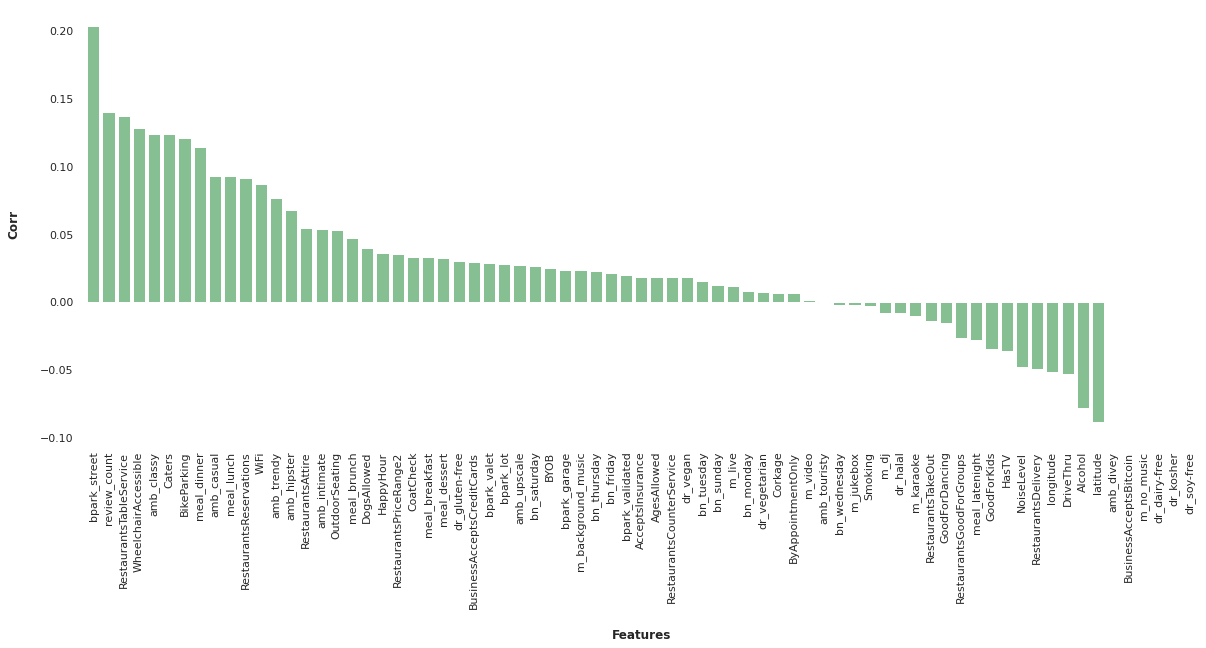

In [ ]:
ax = corr_avg_stars.plot(kind='bar', sharex=False, figsize=(20,8), color = '#86bf91', zorder=2, width=0.8)

#despine
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_xlabel('Features', labelpad=20, weight='bold')
ax.set_ylabel('Corr', labelpad=20, weight='bold')


For Collaborative filtering, we take only the columns with good amount of correlation to do the filtering and prediction.

In [246]:
res=res[['business_id', 'name','stars', 'review_count','Caters','meal_dinner', 'amb_classy', 'amb_hipster', 'amb_divey', 'amb_touristy', 'amb_trendy', 'amb_upscale', 'amb_casual','RestaurantsTakeOut', 'Alcohol', 'GoodForKids', 'RestaurantsPriceRange2', 'RestaurantsAttire', 'RestaurantsDelivery', 'BikeParking','GoodForDancing', 'CoatCheck', 'Smoking','RestaurantsReservations','WiFi','OutdoorSeating']]

In [247]:
res.head()

,business_id,name,stars,review_count,Caters,meal_dinner,amb_classy,amb_hipster,amb_divey,amb_touristy,amb_trendy,amb_upscale,amb_casual,RestaurantsTakeOut,Alcohol,GoodForKids,RestaurantsPriceRange2,RestaurantsAttire,RestaurantsDelivery,BikeParking,GoodForDancing,CoatCheck,Smoking,RestaurantsReservations,WiFi,OutdoorSeating
0,0QjROMVW9ACKjhSEfHqNCQ,Mi Mi Restaurant,4.0,116,0,1,0,0,0,0,0,0,1,1,0,1,1,0,0,1,0,0,0,0,0,0
1,8k62wYhDVq1-652YbJi5eg,Tim Hortons,3.0,8,0,0,0,0,0,0,0,0,0,1,2,1,1,0,0,0,0,0,0,0,0,0
2,0DnQh8SE8BSnvJltGCCiWg,Chick-N-Joy,3.0,11,1,0,0,0,0,0,0,0,0,1,2,1,2,0,1,1,0,0,0,0,0,1
3,NLaK58WvlNQdUunSIkt-jA,Zav Coffee Shop & Gallery,4.5,24,0,0,0,0,0,0,0,0,0,1,2,0,1,3,0,1,0,0,0,0,1,1
4,cicPsia8Wj-DNRkmLbD_xg,The Keg Steakhouse + Bar,3.5,91,0,1,1,0,0,0,0,0,0,1,1,1,3,0,0,1,0,0,0,1,1,0


In [248]:
reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,response
25,mM8i91yWP1QbImEvz5ds0w,TZQSUDDcA4ek5gBd6BzcjA,qUWqjjjfpB2-4P3He5rsKw,4.0,0,0,0,1
44,nAm92_-WUQ084x9Uz9iFmA,iFEM16O5BeKvf_AHs6NzUQ,9Eghhu_LzEJgDKNgisf3rg,3.0,0,0,0,0
114,V3kZd0O3EeVuTBCKOW-M4g,Eg_VTAQwK3CxYTORNRWd2g,4m_hApwQ054v3ue_OxFmGw,5.0,2,0,0,1
134,Lx-ervsT1BqUL7OfW-Lb9A,IIE2OX5haarGNefY23R8BA,jM6JjZXFAQQANwdlEwbH3g,5.0,0,0,0,1
148,saJUbTtnictm8KFx6cNNJA,RRhco4irDXPk5EJmvuwr2w,PMPMHHLe9vFzcR67iCjgLA,5.0,0,0,2,1


Considering only the reviews of restaurants in Toronto:


In [249]:
business=res.business_id.unique()
reviews=reviews[reviews.business_id.isin(business)]



In [258]:
reviews.to_pickle("revTor")
reviews=pd.read_pickle('revTor')

In [259]:
reviews.reset_index()

,index,review_id,user_id,business_id,stars,useful,funny,cool,response
0,25,mM8i91yWP1QbImEvz5ds0w,0,495,4.0,0,0,0,1
1,44,nAm92_-WUQ084x9Uz9iFmA,1,301,3.0,0,0,0,0
2,114,V3kZd0O3EeVuTBCKOW-M4g,2,103,5.0,2,0,0,1
3,134,Lx-ervsT1BqUL7OfW-Lb9A,3,284,5.0,0,0,0,1
4,148,saJUbTtnictm8KFx6cNNJA,4,154,5.0,0,0,2,1
...,...,...,...,...,...,...,...,...,...
338323,8020622,9lEYzla0NLZyMsNV-b53Qg,3374,5245,2.0,3,0,1,0
338324,8020639,rBfr17beQCItyFrqdxOFEw,47295,5283,5.0,2,0,0,1
338325,8020643,X9a03IeCFtSeI1fOaicE2g,28790,5270,5.0,1,1,1,1
338326,8020780,2By_gXjZCbiEE1ZTO6hDcQ,4059,5189,4.0,2,4,4,1


In [252]:
restaurant = res.business_id.unique()
user = reviews.user_id.unique()

In [253]:
#mapping the index of the users and restaurants to replace them with their indexes in the dataset
userid2idx = {o:i for i,o in enumerate(user)}
resid2idx = {o:i for i,o in enumerate(restaurant)}

In [284]:
#making two new columns for the business and user ids to replace with the extracted indexes
reviews['business_id'] = reviews.business_id.apply(lambda x: resid2idx[x])
reviews['user_id'] = reviews.user_id.apply(lambda x: userid2idx[x])

#making the id column for the restaurants
res = res[res.business_id.isin(restaurant)]
res['id'] = res.business_id.apply(lambda x: resid2idx[x])
res.head()

In [261]:
res = res.drop('business_id', axis=1).set_index('id')
res.head() #completed the transformation

,name,stars,review_count,Caters,meal_dinner,amb_classy,amb_hipster,amb_divey,amb_touristy,amb_trendy,amb_upscale,amb_casual,RestaurantsTakeOut,Alcohol,GoodForKids,RestaurantsPriceRange2,RestaurantsAttire,RestaurantsDelivery,BikeParking,GoodForDancing,CoatCheck,Smoking,RestaurantsReservations,WiFi,OutdoorSeating
id,,,,,,,,,,,,,,,,,,,,,,,,,
0,Mi Mi Restaurant,4.0,116,0,1,0,0,0,0,0,0,1,1,0,1,1,0,0,1,0,0,0,0,0,0
1,Tim Hortons,3.0,8,0,0,0,0,0,0,0,0,0,1,2,1,1,0,0,0,0,0,0,0,0,0
2,Chick-N-Joy,3.0,11,1,0,0,0,0,0,0,0,0,1,2,1,2,0,1,1,0,0,0,0,0,1
3,Zav Coffee Shop & Gallery,4.5,24,0,0,0,0,0,0,0,0,0,1,2,0,1,3,0,1,0,0,0,0,1,1
4,The Keg Steakhouse + Bar,3.5,91,0,1,1,0,0,0,0,0,0,1,1,1,3,0,0,1,0,0,0,1,1,0


In [262]:
reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,response
25,mM8i91yWP1QbImEvz5ds0w,0,495,4.0,0,0,0,1
44,nAm92_-WUQ084x9Uz9iFmA,1,301,3.0,0,0,0,0
114,V3kZd0O3EeVuTBCKOW-M4g,2,103,5.0,2,0,0,1
134,Lx-ervsT1BqUL7OfW-Lb9A,3,284,5.0,0,0,0,1
148,saJUbTtnictm8KFx6cNNJA,4,154,5.0,0,0,2,1


In [263]:
restaurant_names = res.name.to_dict() #transformed key:restaurant name
restaurant_names

{0: 'Mi Mi Restaurant',
 1: 'Tim Hortons',
 2: 'Chick-N-Joy',
 3: 'Zav Coffee Shop & Gallery',
 4: 'The Keg Steakhouse + Bar',
 5: 'Fearless Meat',
 6: 'St. Louis Bar & Grill',
 7: "Mi'Hito Sushi Laboratory",
 8: 'Edulis',
 9: 'Spiga Ristorante',
 10: 'Martins',
 11: 'Bistro Grande',
 12: 'Veghed',
 13: 'Kinoya Sushi Bar',
 14: 'Skippa',
 15: 'Chopin Restaurant',
 16: 'Xe Lua Restaurant',
 17: 'My Roti Place',
 18: 'Plentea',
 19: 'Anoush Shawarma',
 20: 'Akira Back',
 21: 'Heart Clean Eats',
 22: "Better than Yia Yia's",
 23: 'Best Bite Bar & Grill',
 24: 'Chicken Monster',
 25: 'Baby Point Lounge',
 26: 'Pizza Cafe',
 27: 'Pagoda',
 28: 'DeCourses Café',
 29: 'Bar Centrale',
 30: 'Mezbaan Food',
 31: '00 Gelato',
 32: 'Chinese Egg Waffle Vendor',
 33: 'Subway',
 34: 'Burrito Boyz',
 35: 'Korean Grill House',
 36: "McDonald's",
 37: 'Mercado Negro',
 38: 'Freshii',
 39: 'Dessert Lady Café',
 40: 'Kay Pacha',
 41: 'The Fish Store & Sandwiches',
 42: 'Sugar Marmalade',
 43: 'The Carlton

In [264]:
reviews.to_csv("ratings_contig.csv", index=False)
res.to_csv("restaurants_contig.csv", index=False)

In [265]:
nusers = reviews.user_id.nunique()
nresto = reviews.business_id.nunique()#number of restaurants that have been rated
nusers, nresto

(90665, 5462)

###Model using Neural Networks:


In [266]:
np.random.seed=2017
from sklearn.model_selection import train_test_split
#splitting the reviews dataset in 80:20 ratio
train_indices, val_indices = train_test_split(range(reviews.shape[0]), train_size=0.8)
#the data obtained
trdf = reviews.iloc[train_indices]
valdf = reviews.iloc[val_indices]

trdf.shape, valdf.shape

((270662, 8), (67666, 8))

In [267]:
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Add, Dot, Flatten
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [268]:
#regularisation metrics for the embedding matrix
L=40
REG=5e-4

In [270]:
def create_bias(name, inp, n_in, reg):
    x = Embedding(n_in, 1, input_length=1, name=name)(inp)
    return Flatten(name=name+'_flat')(x)

In [271]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, name=name.split('_')[0]+'_factor', embeddings_regularizer=l2(reg))(inp)

In [284]:
#obtaining the latent factor matrices and the inputs required to create the bias
user_input, uLmat = embedding_input('user_input', nusers, L, REG)
res_input, rLmat = embedding_input('res_input', nresto, L, REG)

In [273]:
uLmat.shape, rLmat.shape

(TensorShape([None, 1, 40]), TensorShape([None, 1, 40]))

In [274]:
#creating the offsets
user_bias = create_bias('user_bias', user_input, nusers, REG)
res_bias = create_bias('res_bias', res_input, nresto, REG)

In [275]:
#the residual factors
residual = Dot(axes=2, name="residual")([uLmat, rLmat])

In [276]:
#flattened to be used for the linear regression model
residflat = Flatten(name="residual_flat")(residual)
residflat.shape

TensorShape([None, 1])

In [277]:
#linear regression model for rating prediction
regression = Add(name="regression")([user_bias, res_bias,residflat])

In [278]:
from tensorflow.keras.layers import Activation
from tensorflow.keras import backend as K

In [279]:
#custom sigma function to limit the predictions within 0 and 5
def sigmoid_maker(low, high):
    def custom_sigmoid(x):
        return K.sigmoid(x)*(high - low) + low #within range
    return custom_sigmoid
cs = sigmoid_maker(0, 5.5)

In [280]:
output = Activation(cs, name="Sigmoid_Range")(regression)

In [281]:
model = Model([user_input, res_input], output)
model.compile(Adam(0.001), loss='mse')

In [282]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
res_input (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_factor (Embedding)         (None, 1, 40)        3626600     user_input[0][0]                 
__________________________________________________________________________________________________
res_factor (Embedding)          (None, 1, 40)        218480      res_input[0][0]                  
______________________________________________________________________________________________

In [285]:
model.optimizer.lr=0.001
model.fit([trdf.user_id, trdf.business_id], trdf.stars,
 batch_size=64,
 epochs=4,
 validation_data=([valdf.user_id, valdf.business_id],
 valdf.stars))

Epoch 1/4
4230/4230 [==============================] - 175s 41ms/step - loss: 0.7415 - val_loss: 1.5230
Epoch 2/4
4230/4230 [==============================] - 174s 41ms/step - loss: 0.7248 - val_loss: 1.5174
Epoch 3/4
4230/4230 [==============================] - 174s 41ms/step - loss: 0.7179 - val_loss: 1.5163
Epoch 4/4
4230/4230 [==============================] - 175s 41ms/step - loss: 0.7143 - val_loss: 1.5161


The model with a learning rate of 0.001 with epoch 4 seems to overfitting to some extent as the validation loss is almost twice the training loss.


In [286]:
model.optimizer.lr=0.01
model.fit([trdf.user_id, trdf.business_id], trdf.stars,
 batch_size=64,
 epochs=4,
 validation_data=([valdf.user_id, valdf.business_id],
 valdf.stars))

Epoch 1/4
4230/4230 [==============================] - 174s 41ms/step - loss: 0.8579 - val_loss: 1.5684
Epoch 2/4
4230/4230 [==============================] - 174s 41ms/step - loss: 0.8620 - val_loss: 1.5777
Epoch 3/4
4230/4230 [==============================] - 175s 41ms/step - loss: 0.8544 - val_loss: 1.5788
Epoch 4/4
4230/4230 [==============================] - 176s 42ms/step - loss: 0.8586 - val_loss: 1.5791


This too, doesn't seem to do any better. There is a slight amount of improvement in the overfitting as it seems to less-overfit compared to the previous case.

In [283]:
model.optimizer.lr=0.01
model.fit([trdf.user_id, trdf.business_id], trdf.stars,
 batch_size=64,
 epochs=6,
 validation_data=([valdf.user_id, valdf.business_id],
 valdf.stars))

Epoch 1/6
4230/4230 [==============================] - 194s 46ms/step - loss: 1.6840 - val_loss: 1.3770
Epoch 2/6
4230/4230 [==============================] - 189s 45ms/step - loss: 1.1072 - val_loss: 1.4168
Epoch 3/6
4230/4230 [==============================] - 187s 44ms/step - loss: 0.9572 - val_loss: 1.4584
Epoch 4/6
4230/4230 [==============================] - 187s 44ms/step - loss: 0.8771 - val_loss: 1.5007
Epoch 5/6
4230/4230 [==============================] - 184s 44ms/step - loss: 0.8395 - val_loss: 1.5325
Epoch 6/6
4230/4230 [==============================] - 184s 44ms/step - loss: 0.8273 - val_loss: 1.5493


###Predictions:

In [287]:
dfpreds = reviews[['business_id', 'stars', 'user_id']].copy()
dfpreds['predictions'] = model.predict([dfpreds.user_id, dfpreds.business_id]).ravel()

Text(0, 0.5, 'prediction')

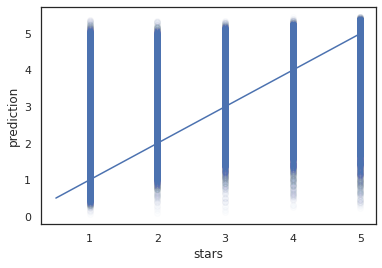

In [288]:
plt.scatter(dfpreds.stars, dfpreds.predictions, alpha=0.01)
plt.plot([0.5,5],[0.5,5])
plt.xlabel("stars")
plt.ylabel("prediction")

The predictions, as expected based on the validation loss, don't seem to do a great job.

In [289]:
preds_stats=dfpreds.groupby('stars')['predictions'].describe().reset_index()
preds_stats

,stars,count,mean,std,min,25%,50%,75%,max
0,1.0,32329.0,2.157571,1.148690,0.052712,1.085001,1.994883,3.080658,5.383076
1,2.0,32204.0,2.936366,0.853187,0.088554,2.251529,2.949141,3.572078,5.355071
2,3.0,57906.0,3.422256,0.667693,0.124905,2.985748,3.440082,3.889234,5.342677
3,4.0,108510.0,3.845764,0.596217,0.248035,3.514675,3.915976,4.246933,5.451511
4,5.0,107379.0,4.389410,0.685985,0.235836,4.006030,4.545713,4.944870,5.461556


In [290]:
preds_stats_train = dfpreds.iloc[train_indices].groupby('stars')['predictions'].describe().reset_index()
preds_stats_train

,stars,count,mean,std,min,25%,50%,75%,max
0,1.0,25839.0,1.952157,1.073697,0.113278,1.024993,1.594272,2.801046,5.190583
1,2.0,25846.0,2.856867,0.824697,0.373211,2.178819,2.846211,3.476182,5.309137
2,3.0,46237.0,3.404047,0.637898,0.507331,2.978408,3.414418,3.854758,5.312700
3,4.0,86842.0,3.866524,0.556649,0.248035,3.553606,3.931516,4.243922,5.406228
4,5.0,85898.0,4.488282,0.608401,0.401716,4.139508,4.651324,4.973113,5.461556


Text(0, 0.5, 'prediction')

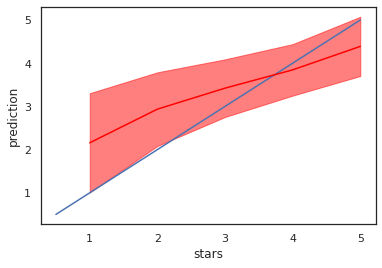

In [291]:
preds_stats_val = dfpreds.iloc[val_indices].groupby('stars')['predictions'].describe().reset_index()
preds_stats_val
plt.plot([0.5,5],[0.5,5])
plt.plot(preds_stats.stars, preds_stats['mean'], color="red")
plt.fill_between(preds_stats.stars, preds_stats['mean']-preds_stats['std'], preds_stats['mean']+preds_stats['std'], color="red", alpha=0.5)
plt.xlabel("stars")
plt.ylabel("prediction")

In this graph, we understand that our model does well in cases where the rating is somewhere close to 4 i.e (3.5,4.5) region and in the rest areas, it does terribly bad.

Text(0.5, 1.0, 'train')

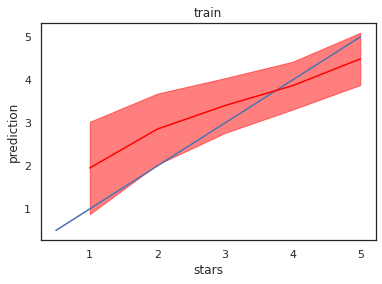

In [292]:
plt.plot([0.5,5],[0.5,5])
plt.plot(preds_stats_train.stars, preds_stats_train['mean'], color="red")
plt.fill_between(preds_stats_train.stars, preds_stats_train['mean']-preds_stats_train['std'], preds_stats_train['mean']+preds_stats_train['std'], color="red", alpha=0.5)
plt.xlabel("stars")
plt.ylabel("prediction")
plt.title('train')


Text(0.5, 1.0, 'val')

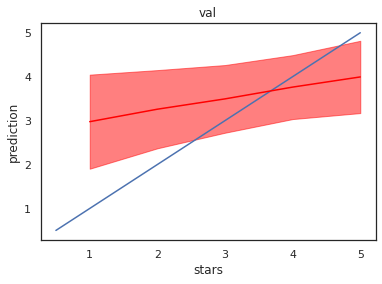

In [293]:
plt.plot([0.5,5],[0.5,5])
plt.plot(preds_stats_val.stars, preds_stats_val['mean'], color="red")
plt.fill_between(preds_stats_val.stars, preds_stats_val['mean']-preds_stats_val['std'], preds_stats_val['mean']+preds_stats_val['std'], color="red", alpha=0.5)
plt.xlabel("stars")
plt.ylabel("prediction")
plt.title('val')

Specifically in the test cases, the model predicts somewhere close to the actual ratings, whereas in the lower ratings, it doesn't do a great job.